trained with single, and test on multi

In [1]:
# set current directory (where this repo is located)
import os
PROJECT_ROOT = '/home/young/workspace/reconstruction/recon-mnistc'
os.chdir(PROJECT_ROOT)
print('current directory:', os.getcwd())

current directory: /home/young/workspace/reconstruction/recon-mnistc


In [15]:
# load required libraries & modules
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import pprint
import time
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch

from utils import *
from loaddata import *
from visualization import *
from ourmodel_multi import *

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False)

DATA_DIR = './data'
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

BATCHSIZE = 100
ACC_TYPE = "entropy@2"

# general helper funtions for model testing
def load_model(args):
    # load model
    model = RRCapsNet(args).to(args.device) 
    model.load_state_dict(torch.load(args.load_model_path))
    return model

def load_args(load_model_path, args_to_update, verbose=False):
    params_filename = os.path.dirname(load_model_path) + '/params.txt'
    assert os.path.isfile(params_filename), "No param flie exists"
    args = parse_params_wremove(params_filename, removelist = ['device']) 
    args = update_args(args, args_to_update)
    args.load_model_path = load_model_path
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    return args


def get_first_two_true_index(boolarray, axis=1, when_no_true='final_index'):
    # boolarray = Batch x Stepsize
    first_true_index = ((boolarray.cumsum(axis) == 1) & boolarray).max(axis, keepdim=True)[1] # when no true, set as 0
    second_true_index = ((boolarray.cumsum(axis) == 2) & boolarray).max(axis, keepdim=True)[1] # when no true, set as 0
    
    if when_no_true == 'final_index': # when there is no true, use final index
        all_false_condition = (~boolarray).all(dim=1).reshape(-1,1)
        first_true_index = first_true_index + all_false_condition*(boolarray.shape[1]-2) #second to final index
        second_true_index = second_true_index + all_false_condition*(boolarray.shape[1]-1) #final index
        return  first_true_index, second_true_index, all_false_condition
    else:
        return first_true_index, second_true_index


def get_seqaccs(y_pred_step, y_hot, evaluate_at_which_step, topk):
    # slice based on below_threhold_step
    first_true_index, second_true_index, all_false_index = get_first_two_true_index(evaluate_at_which_step.bool(), axis=1)
    
    y_pred_first = torch.stack([y_pred_step[i, first_true_index.flatten()[i], :] for i in range(y_pred_step.size(0))]) #([1000, n_step, 10]) --> ([1000, 10])
    top1pred_first = torch.argmax(y_pred_first, dim=1)
    
    y_pred_second = torch.stack([y_pred_step[i, second_true_index.flatten()[i], :] for i in range(y_pred_step.size(0))]) #([1000, n_step, 10]) --> ([1000, 10])
    top1pred_second = torch.argmax(y_pred_second, dim=1)

    y_pred_combined = torch.stack([top1pred_first,top1pred_second], dim=-1)
    y_pred_hot = torch.zeros(y_hot.size(), device=y_hot.device).scatter_(1, y_pred_combined, 1.)
    correct = (y_pred_hot*y_hot).sum(dim=-1)
    accs = correct/topk
    return accs, y_pred_combined, first_true_index, second_true_index



@torch.no_grad()
def evaluate_our_acc(task, model, args, train=False, verbose=True, only_acc=True, batchnum=None):
    '''
    topkaccs_all: topkaccs (how many of k objects in the image correctly detected; 1-->2/2, 0.5 -->1/2) using ACC_TYPE
    seqaccs_all: sequential top1-based accuracy (top1 predictions at model's highest confidence (measured by entropy, below theshold), and whether this match with groung truth)
    '''
    # evaluate on one train/test batch 
    model.eval()
    
    dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)    
    diter = iter(dataloader)
    gtx=None

    x_all = []
    y_all = []  
    gtx_all = []
    topk_accs_all = []
    seq_accs_all = []
    objcaps_len_step_all = []
    x_recon_step_all = []
    entropy_step_all = []
    below_threhold_step_all = []

    n_iter = 0
    for x, y in diter:

        if batchnum is not None: # if target batchnum is given, skip until the target batch
            if n_iter < batchnum:
                n_iter += 1
                continue
                
        
        # run model with testing data and get predictions
        x= x.to(args.device)                
        y = y.to(args.device) 
        with torch.no_grad():      
            objcaps_len_step, x_recon_step, entropy_step, below_threhold_step = model(x)
            objcaps_len_step_all.append(objcaps_len_step)
            x_recon_step_all.append(x_recon_step)   
            entropy_step_all.append(entropy_step)
            below_threhold_step_all.append(below_threhold_step)
            # compute loss 
            # loss, loss_class, loss_recon = loss_fn(objcaps_len_step, y, x_recon_step, x, args, gtx=gtx)
            
            # compute topk hypothesis accs 
            objcaps_len_step_narrow = objcaps_len_step.narrow(dim=-1,start=0, length=args.num_classes)
            topk_accs, topk_pred, topk_nstep, iterate_until_max, entropy_step = compute_entropy_based_acc(objcaps_len_step_narrow, y, args.num_targets, threshold=0.6, use_cumulative = False, only_acc=False)
            topk_accs_all.append(topk_accs)

            # compute sequential top1-based accs
            seq_accs, seq_pred, first_true_index, second_true_index = get_seqaccs(objcaps_len_step_narrow, y, below_threhold_step, args.num_targets)
            seq_accs_all.append(seq_accs)

        if verbose:
            print("==> On this sigle test batch: test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
                % (losses[0], losses[1], losses[2], acc))

        x_all.append(x)
        y_all.append(y)
        gtx_all.append(gtx)    
        if batchnum is not None:
            if n_iter == batchnum:
                break

    x_all = torch.cat(x_all, dim=0)
    y_all = torch.cat(y_all, dim=0)
    # gtx_all = torch.cat(gtx_all, dim=0)
    topk_accs_all = torch.cat(topk_accs_all, dim=0)
    seq_accs_all = torch.cat(seq_accs_all, dim=0)
    objcaps_len_step_all = torch.cat(objcaps_len_step_all, dim=0)
    x_recon_step_all = torch.cat(x_recon_step_all, dim=0)
    entropy_step_all = torch.cat(entropy_step_all, dim=0)
    below_threhold_step_all = torch.cat(below_threhold_step_all, dim=0)

    if only_acc:
        return topk_accs_all, seq_accs_all
    else:
        return x_all, gtx_all, y_all, (topk_accs_all, topk_pred), (seq_accs_all, seq_pred), objcaps_len_step_all, x_recon_step_all, entropy_step_all, below_threhold_step_all

@torch.no_grad()
def generate_output_on_batch(task, batchnum, model, args, train=False, verbose=True, onlyacc=False):
    
    # evaluate on one train/test batch 
    model.eval()
    
    if task == 'mnist_recon':
        # for mnist recon data, it has erased input(x) and intact input (gtx)
        if train:
            dataloader, val_dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)
        else:
            dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)            
        diter = iter(dataloader)
        for i in range(batchnum):
            x, gtx, y = next(diter)
    else:
        dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)    
        diter = iter(dataloader)
        for i in range(batchnum):
            x, y = next(diter)
            gtx = None
            
            
    # attach forward hooks for intermediate outputs for visualizations
    outputs = {}
    
    # from model main output
    x_input_step = []; x_mask_step = []; objcaps_step = []
    
    # from model dynamic routing
    coups_step = []; betas_step= []; rscores_step=[]; recon_coups_step=[] 
    outcaps_len_step=[]; outcaps_len_before_step=[]

    def get_attention_outputs():
        def hook(model, input, output):
            x_mask_step.append(output[0].detach())
            x_input_step.append(output[1].detach())
        return hook

    def get_capsule_outputs():
        def hook(model, input, output):
            objcaps_step.append(output[0].detach())
            coups_step.append(torch.stack(output[1]['coups'], dim=1))
            betas_step.append(torch.stack(output[1]['betas'], dim=1)) 
            if 'rscores' in output[1].keys():
                rscores_step.append(torch.stack(output[1]['rscores'], dim=1))
            if 'recon_coups' in output[1].keys():
                recon_coups_step.append(torch.stack(output[1]['recon_coups'], dim=1))
            if 'outcaps_len' in output[1].keys():
                outcaps_len_step.append(torch.stack(output[1]['outcaps_len'], dim=1))
            if 'outcaps_len_before' in output[1].keys():
                outcaps_len_before_step.append(torch.stack(output[1]['outcaps_len_before'], dim=1))
        return hook
    
    
    hook1 = model.input_window.register_forward_hook(get_attention_outputs())
    hook2 = model.capsule_routing.register_forward_hook(get_capsule_outputs())
    
    # evaluate and detach hooks
    x_batch, gtx_batch, y_batch, (topk_accs, topk_pred), (seq_accs, seq_pred), objcaps_len_step, x_recon_step, entropy_step, below_threhold_step = evaluate_our_acc(task, model, args, train, verbose=False, only_acc=False, batchnum=batchnum)
    hook1.remove()
    hook2.remove()
    

    # add tensor outputs dictionary
    outputs['x_input'] = torch.stack(x_input_step, dim=1)
    outputs['x_mask'] = torch.stack(x_mask_step, dim=1)
    outputs['objcaps'] = torch.stack(objcaps_step, dim=1)
    
    outputs['coups'] = torch.stack(coups_step, dim=1)
    outputs['betas'] = torch.stack(betas_step, dim=1)
    if rscores_step:
        outputs['rscores'] = torch.stack(rscores_step, dim=1)
    if recon_coups_step:
        outputs['recon_coups'] = torch.stack(recon_coups_step, dim=1)
    if outcaps_len_step:
        outputs['outcaps_len'] = torch.stack(outcaps_len_step, dim=1)
    if outcaps_len_before_step:
        outputs['outcaps_len_before'] = torch.stack(outcaps_len_before_step, dim=1)        
    if verbose:
        print("==> On this sigle test batch: test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
              % (losses[0], losses[1], losses[2], acc))
    
    if onlyacc:
        return topkaccs
    else:
        return x_batch, gtx_batch, y_batch, (topk_accs, topk_pred), (seq_accs, seq_pred), objcaps_len_step, x_recon_step, entropy_step, below_threhold_step, outputs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load model and evaluate performance

In [ ]:
task='mnist_multi' # 'mnist_multi_high', 'mnist_recon'
train=False #train or test dataset
print_args=False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 'num_targets':2,
                 'time_steps': 10, 'routings':3 , 'mask_threshold': 0.1}


modellist = [
    './results/mnist/Feb20_2245_mnist_shift_single_36/best_epoch32_acc1.0000.pt', #single mnist with shift
             ]

df = pd.DataFrame()
for i, load_model_path in enumerate(modellist):
    
    args = load_args(load_model_path, args_to_update, print_args)
    model = load_model(args)
    print(f'model is loaded from {load_model_path}')
    
    topk_obj_accs, seq_obj_accs = evaluate_our_acc(task, model, args, train, verbose=False)
    topk_img_accs = (topk_obj_accs == 1).float()
    seq_img_accs = (seq_obj_accs == 1).float()
    
    df[load_model_path] = [topk_obj_accs.mean().item(), topk_img_accs.mean().item(), seq_obj_accs.mean().item(), seq_img_accs.mean().item()]

df.index = ['topk_obj_acc', 'topk_img_acc', 'seq_obj_acc', 'seq_img_acc']

display(df)
print('# testing images:', len(topk_obj_accs))




# evaluate on batch for visualizations

In [16]:
task='mnist_multi' # 'mnist_multi_high', 'mnist_recon'
train=False #train or test dataset
print_args=False

args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 'num_targets':2,
                 'time_steps': 5, 'routings':3 , 'mask_threshold': 0.1}
load_model_path =  './results/mnist/Feb20_2245_mnist_shift_single_36/best_epoch32_acc1.0000.pt'

# load model
args = load_args(load_model_path, args_to_update, print_args)
model = load_model(args)
print(f'model is loaded from {load_model_path}')

# generate output on a batch
batchnum = 1
x, gtx, y_hot, (topk_obj_accs, topk_pred), (seq_obj_accs, seq_pred), objcaps_len_step, x_recon_step, entropy_step, below_threhold_step, outputs_model  = generate_output_on_batch(task, batchnum, model, args, train, verbose=False, onlyacc=False)
topk_img_accs = (topk_obj_accs == 1).float()
seq_img_accs = (seq_obj_accs == 1).float()
print('# testing images:', len(topk_obj_accs))
print('object-level acc for this batch', round(seq_obj_accs.mean().item(),2),  'img-level acc', round(seq_img_accs.mean().item(),2))


# mnist_overlap_4pix_nodup_1fold_36width_2obj_train.pt mnist_overlap_4pix_nodup_1fold_36width_2obj_test.pt
# # testing images: 1000
# object-level acc for this batch 0.64 img-level acc 0.35


=========== model instantiated like below: =============
TASK: mnist_shift (# targets: 2, # classes: 10, # background: 0)
TIMESTEPS #: 5
ENCODER: resnet w/ None projection
...resulting primary caps #: 512, dim: 8
ROUTINGS # 3
Object #: 10, BG Capsule #: 0
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.1, apply_method match

model is loaded from ./results/mnist/Feb20_2245_mnist_shift_single_36/best_epoch32_acc1.0000.pt
mnist_overlap_4pix_nodup_1fold_36width_2obj_train.pt mnist_overlap_4pix_nodup_1fold_36width_2obj_test.pt
mnist_overlap_4pix_nodup_1fold_36width_2obj_train.pt mnist_overlap_4pix_nodup_1fold_36width_2obj_test.pt
# testing images: 100
object-level acc for this batch 0.62 img-level acc 0.38


In [25]:
np.array(set([2,1])) == np.array(set([1,2]))

True



================ TRIAL 0 ===================


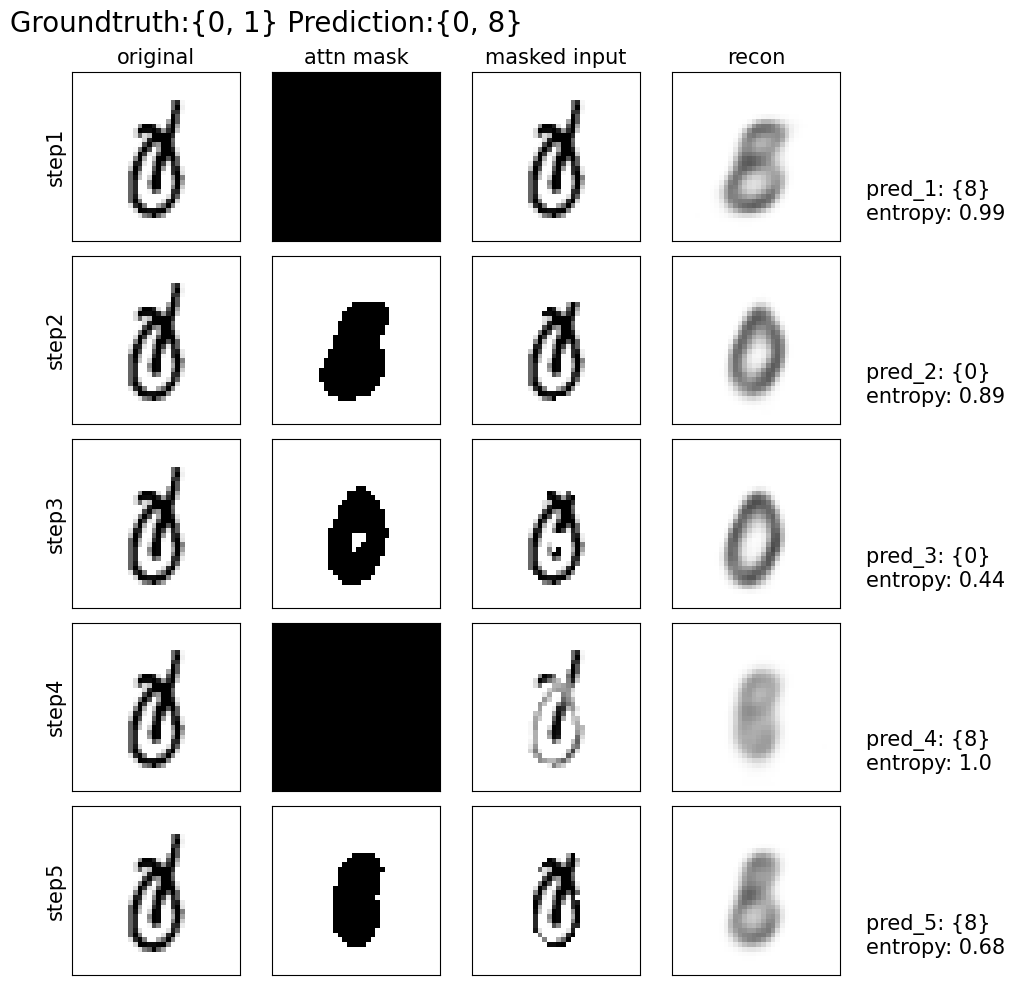

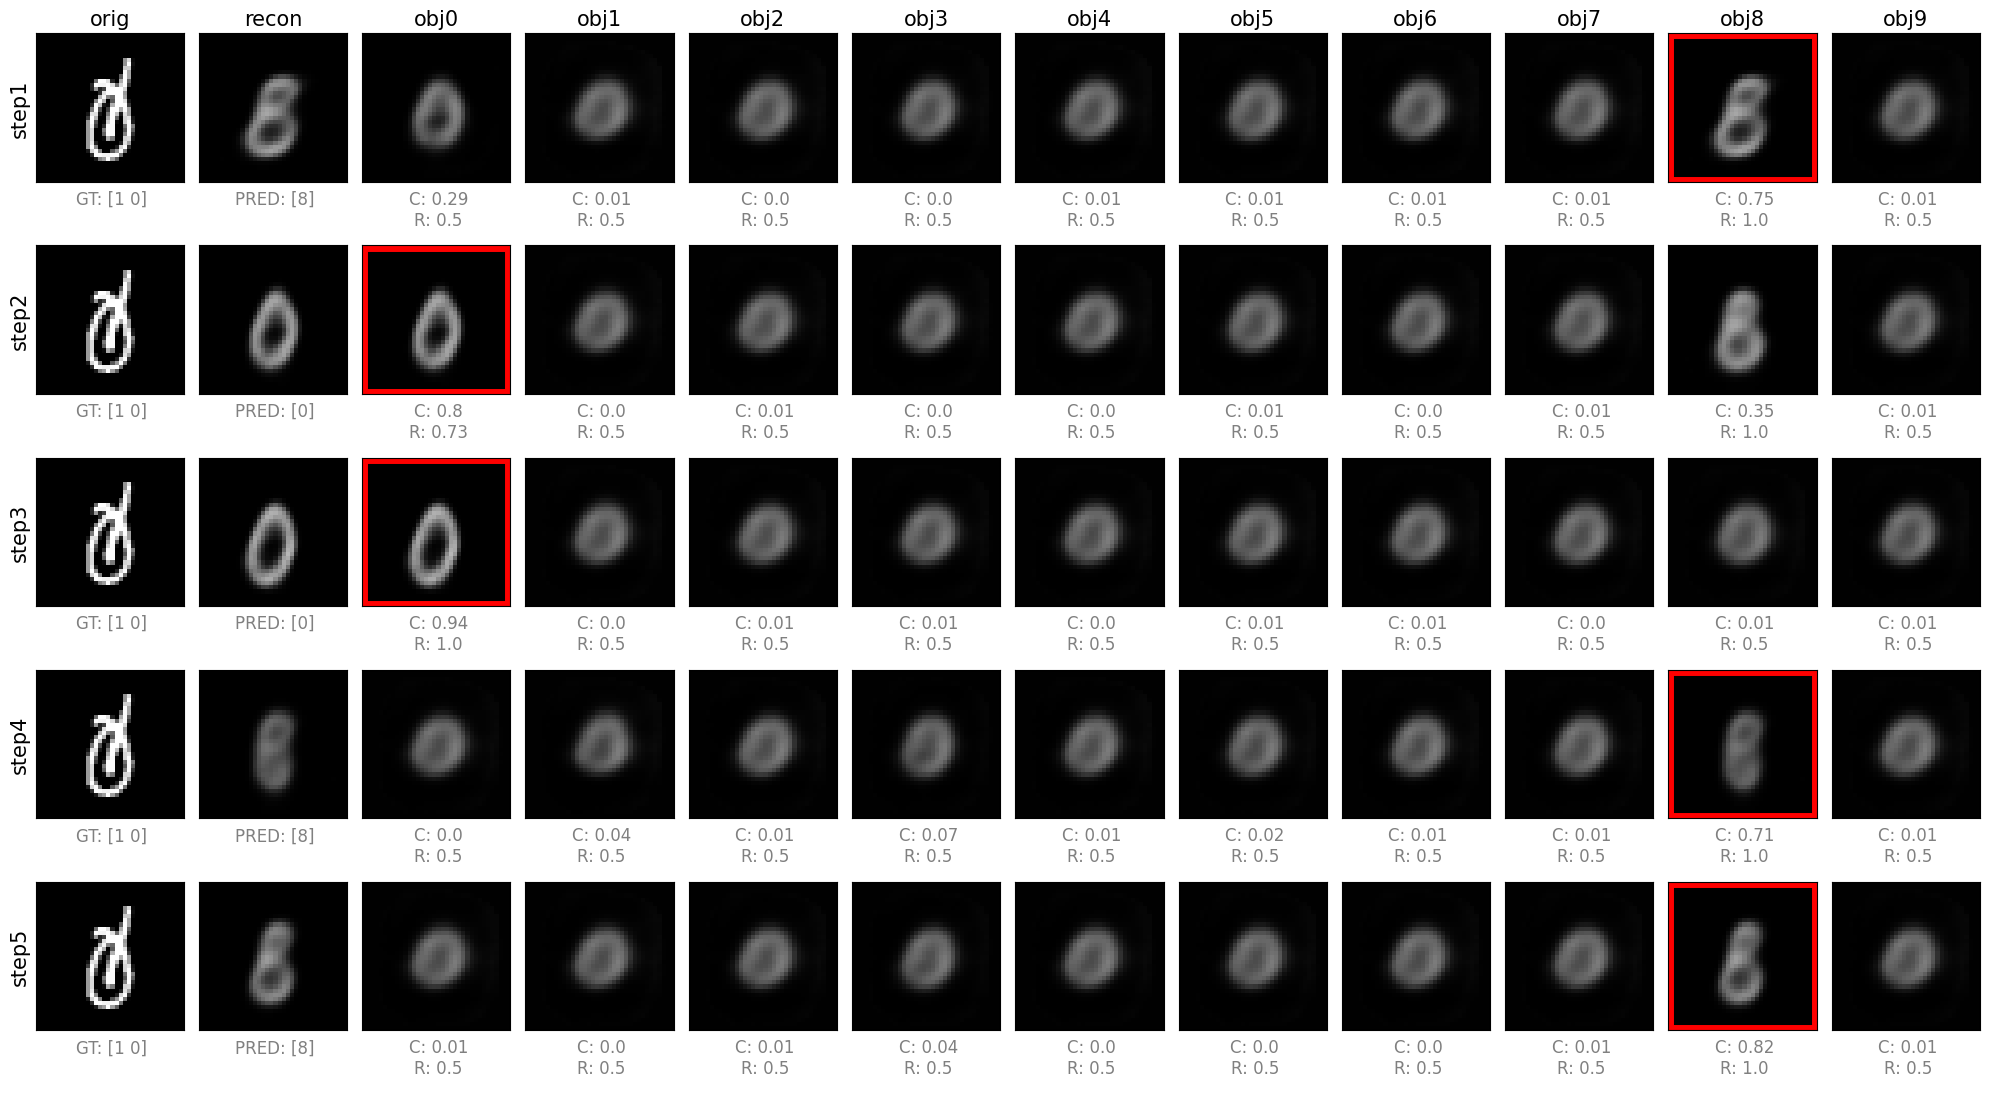



================ TRIAL 1 ===================


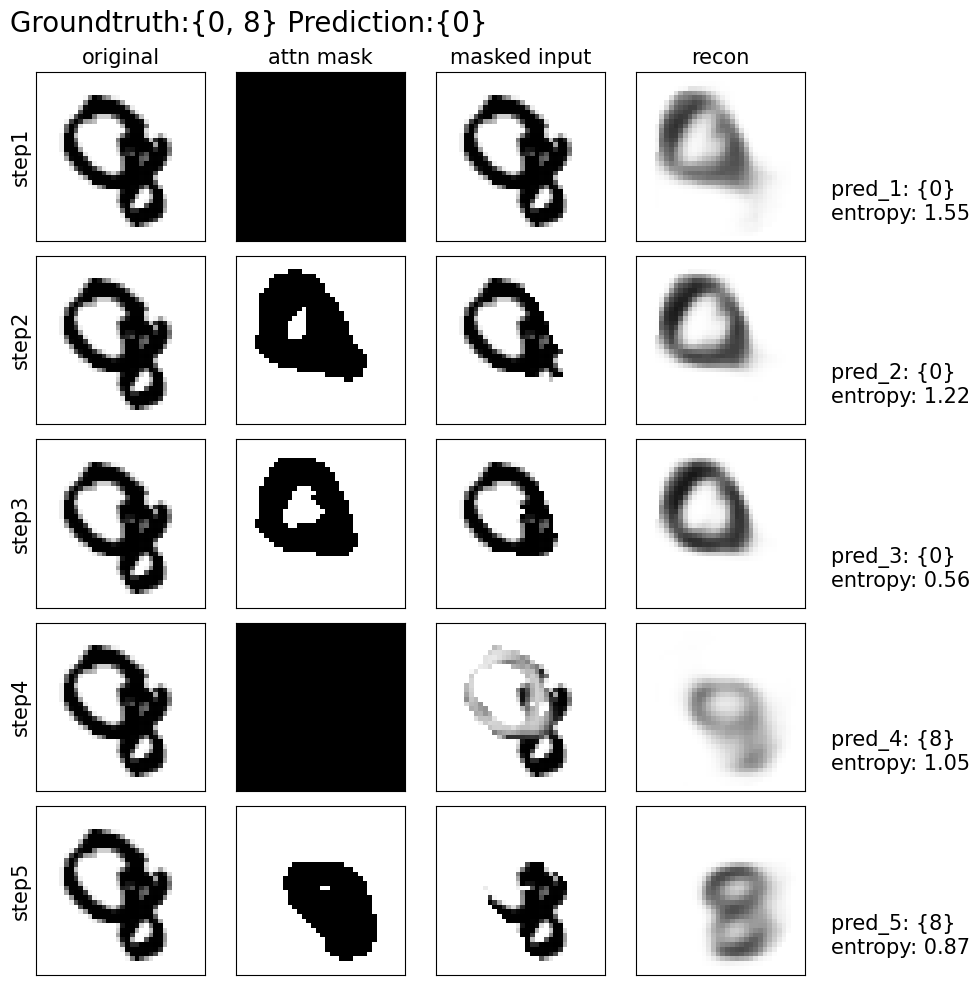

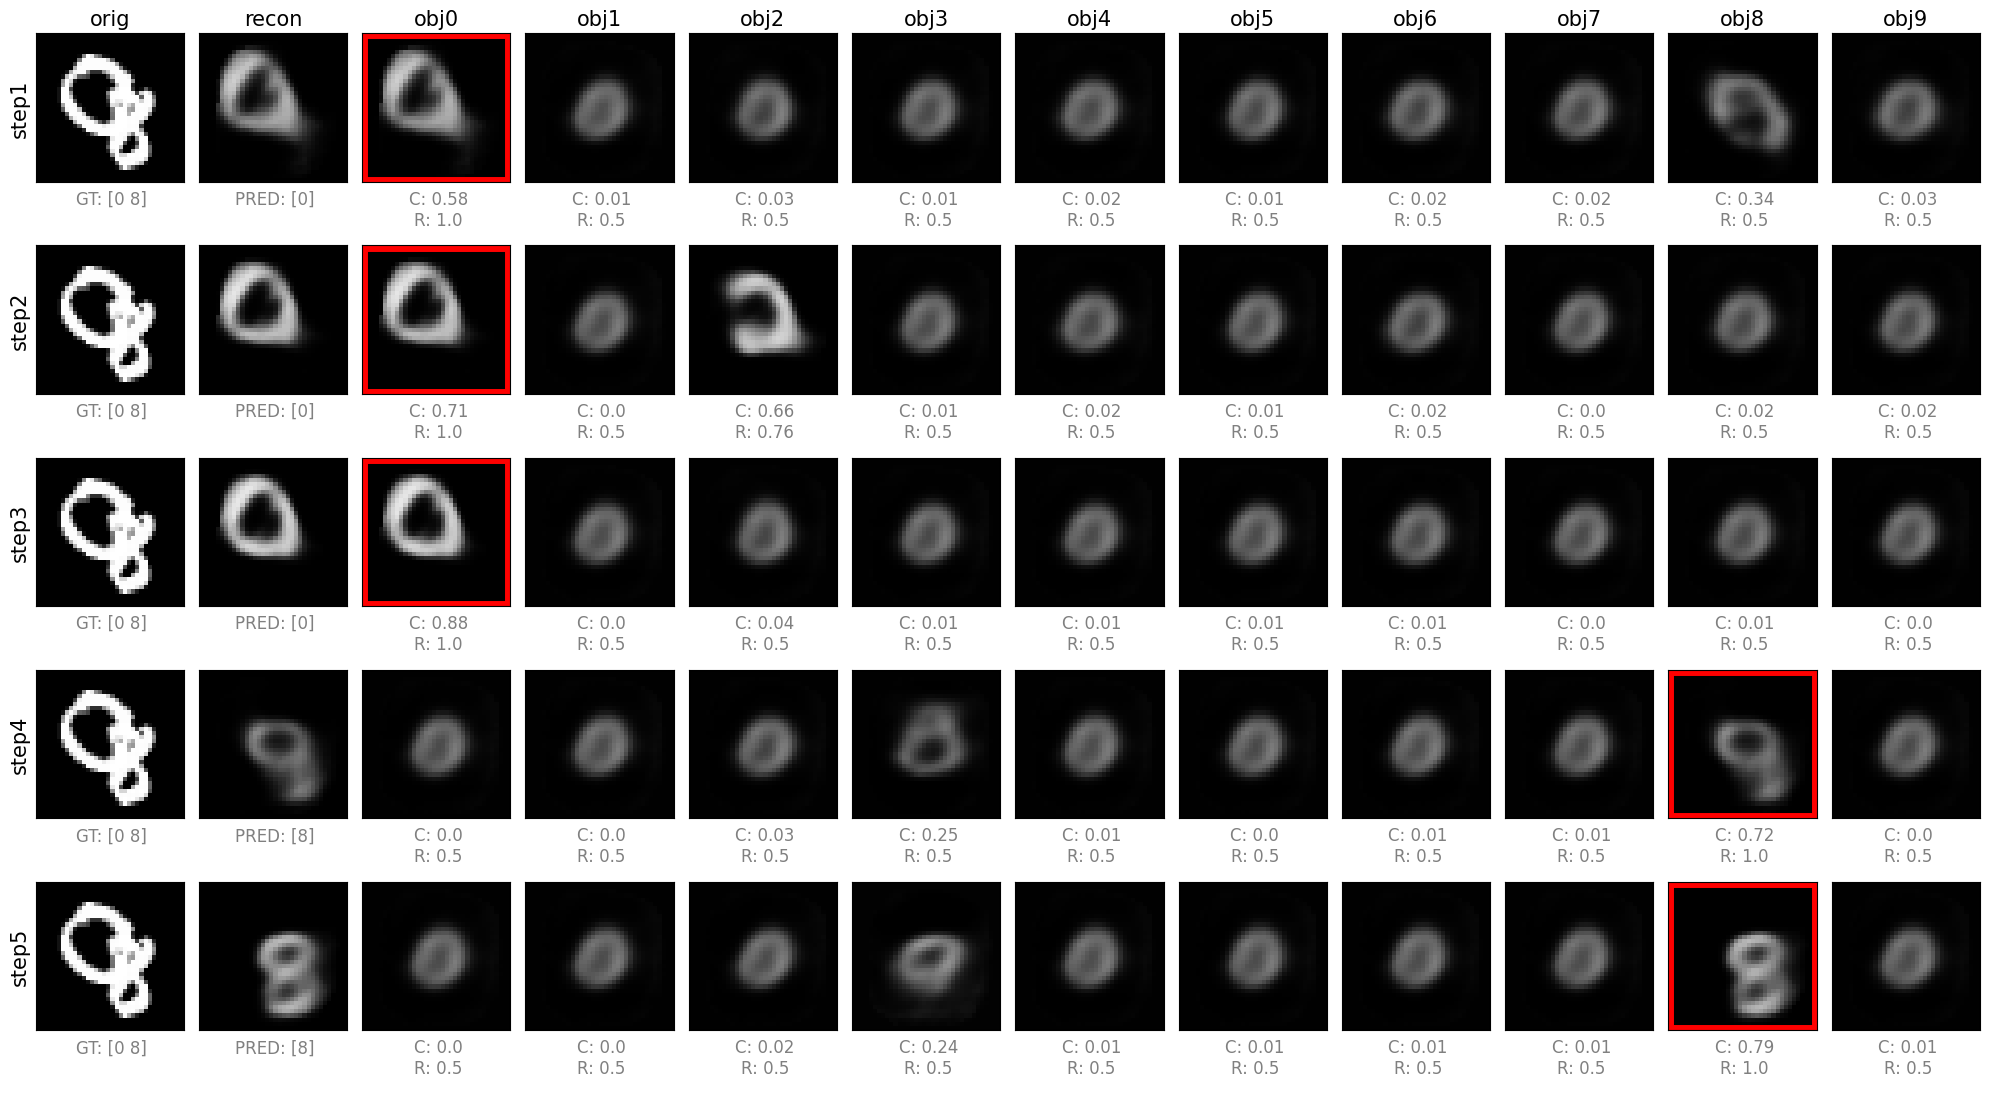



================ TRIAL 2 ===================


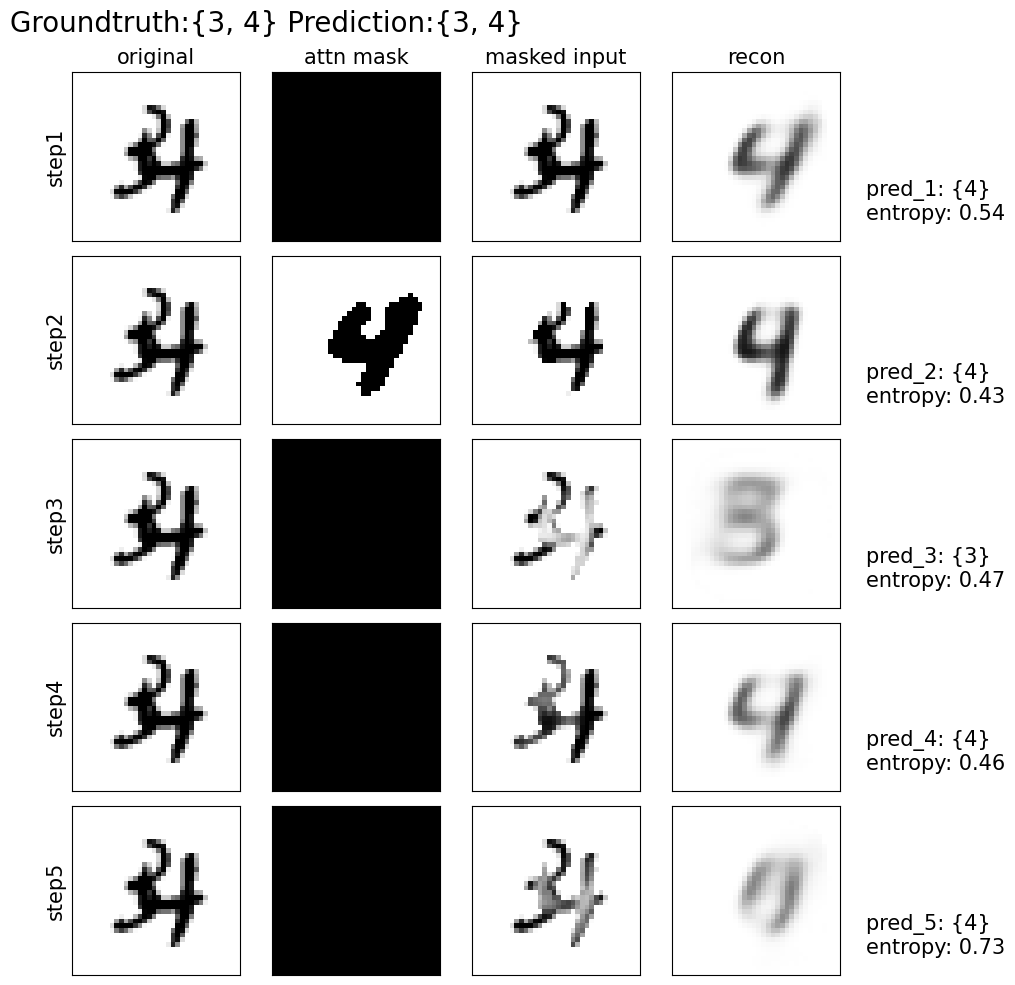

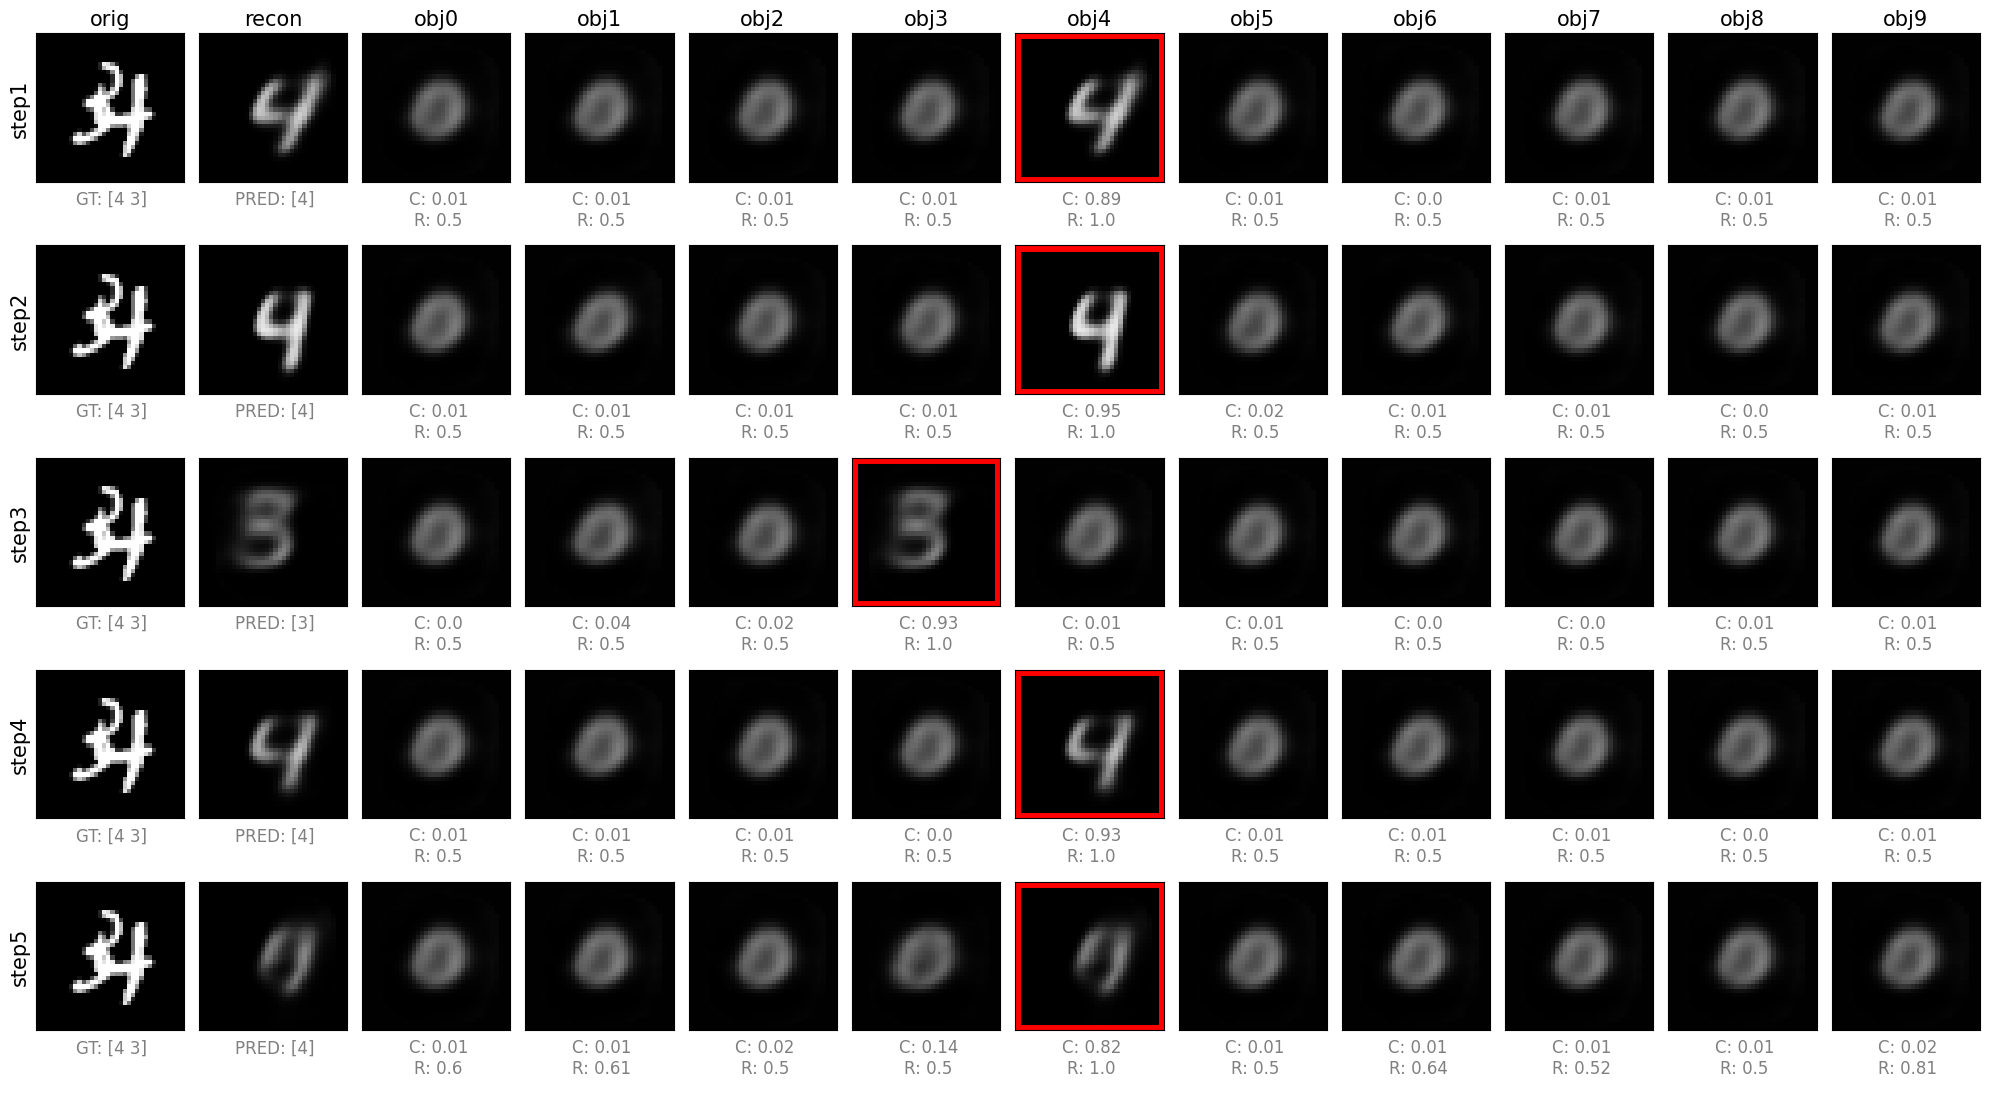



================ TRIAL 3 ===================


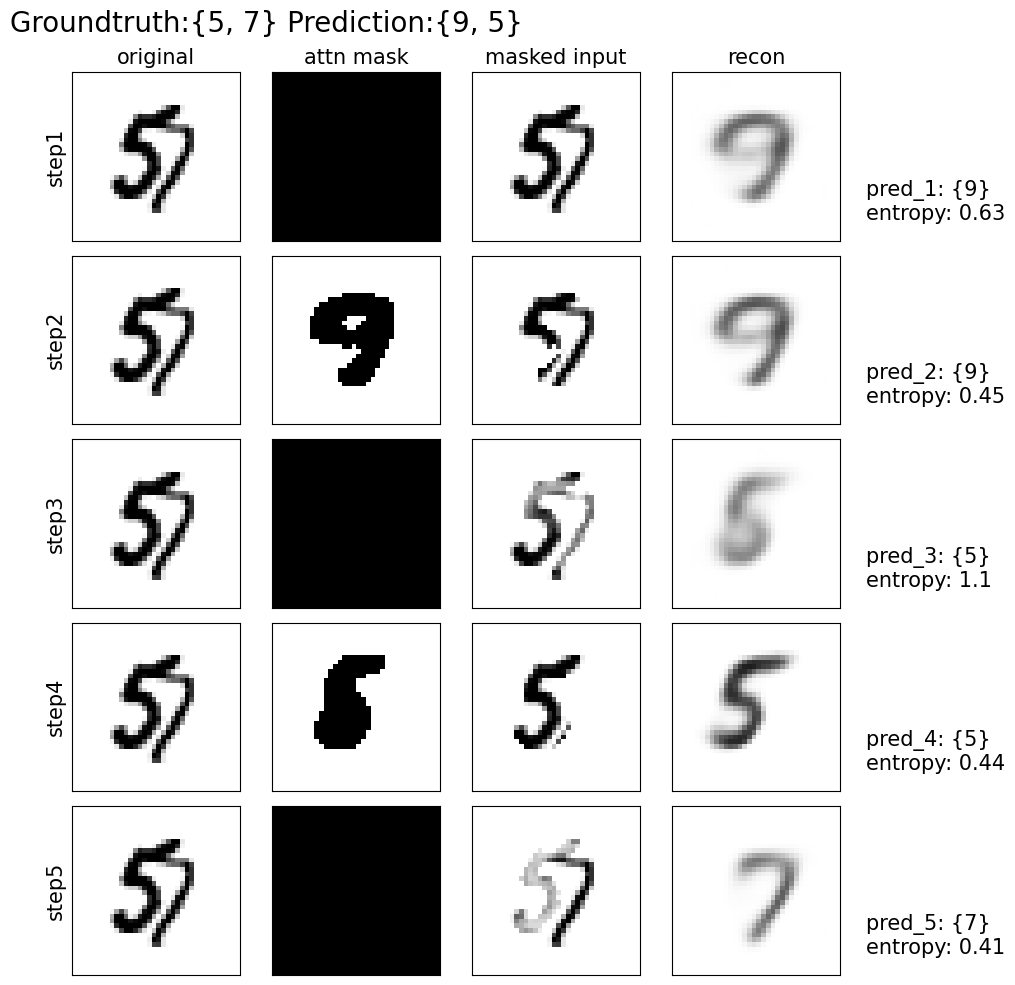

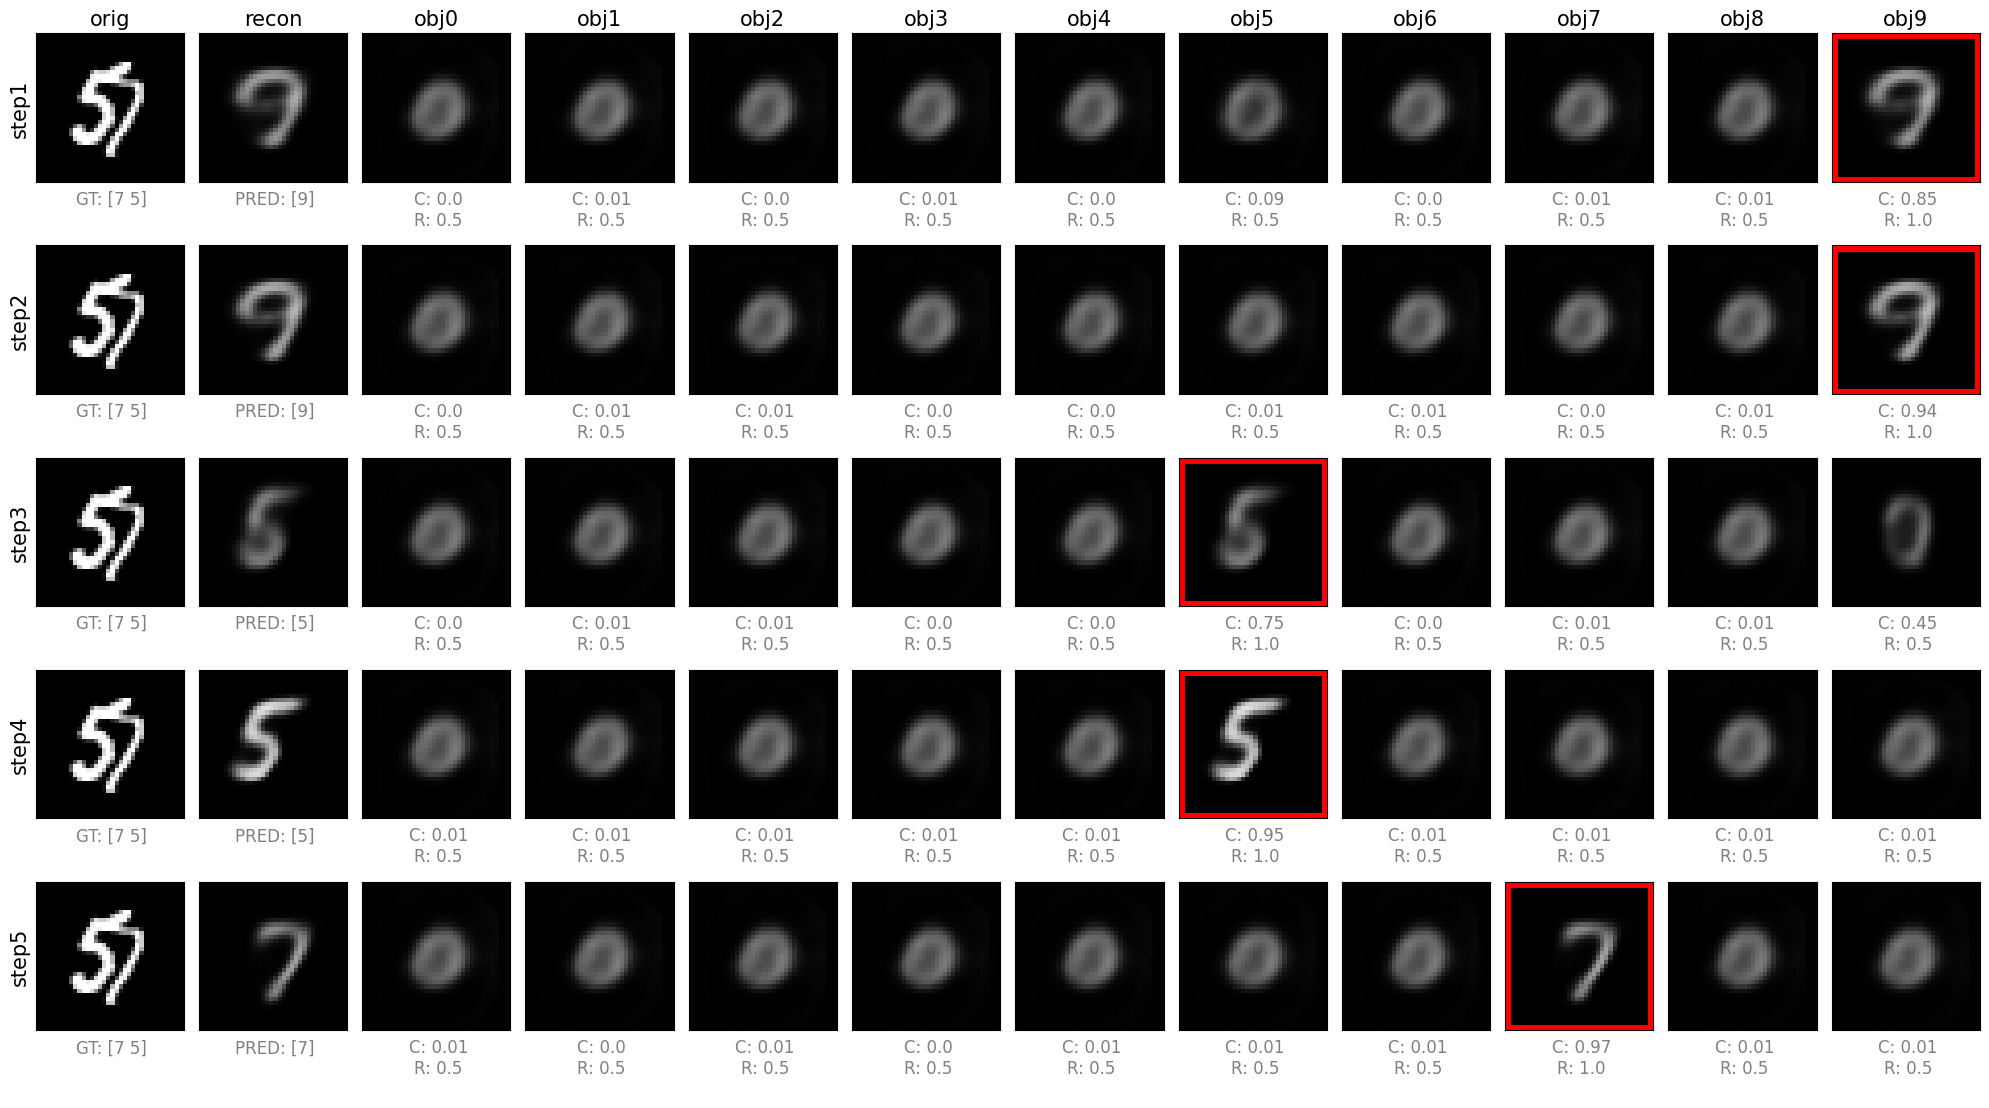



================ TRIAL 4 ===================


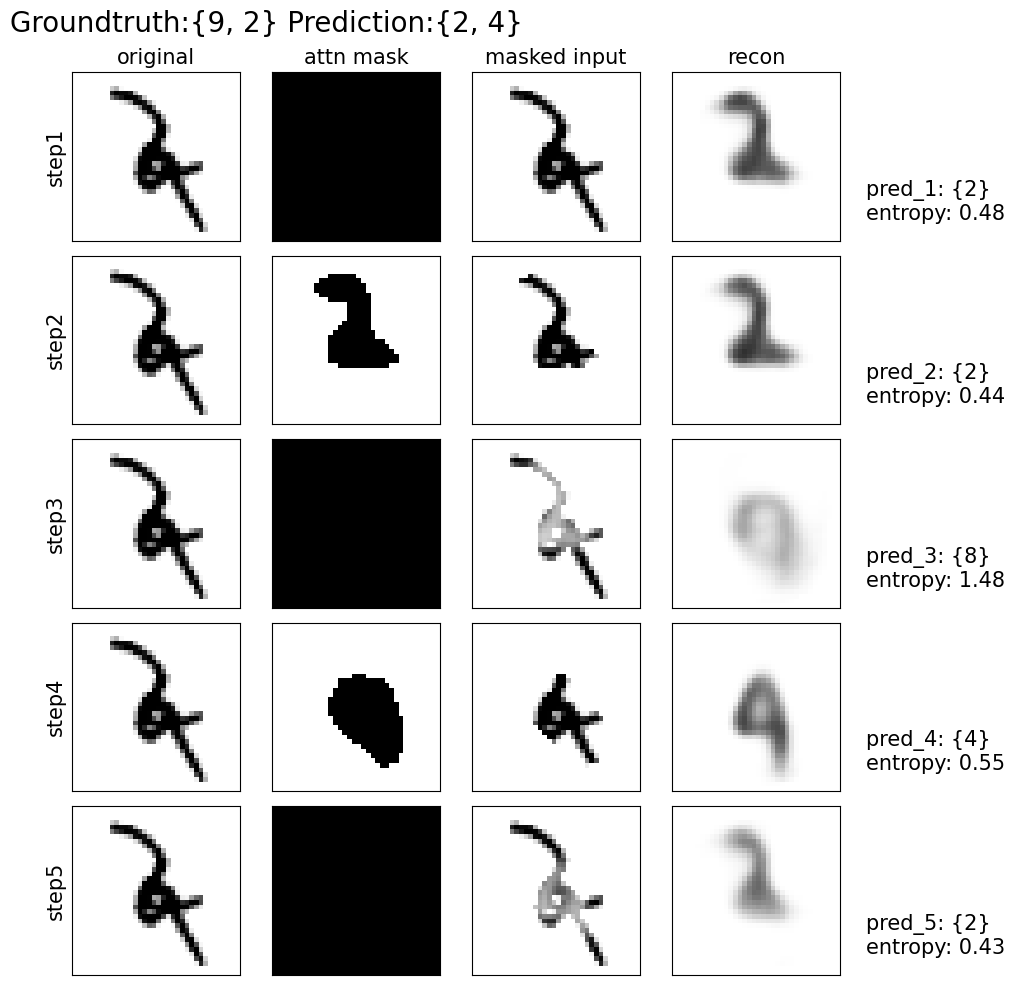

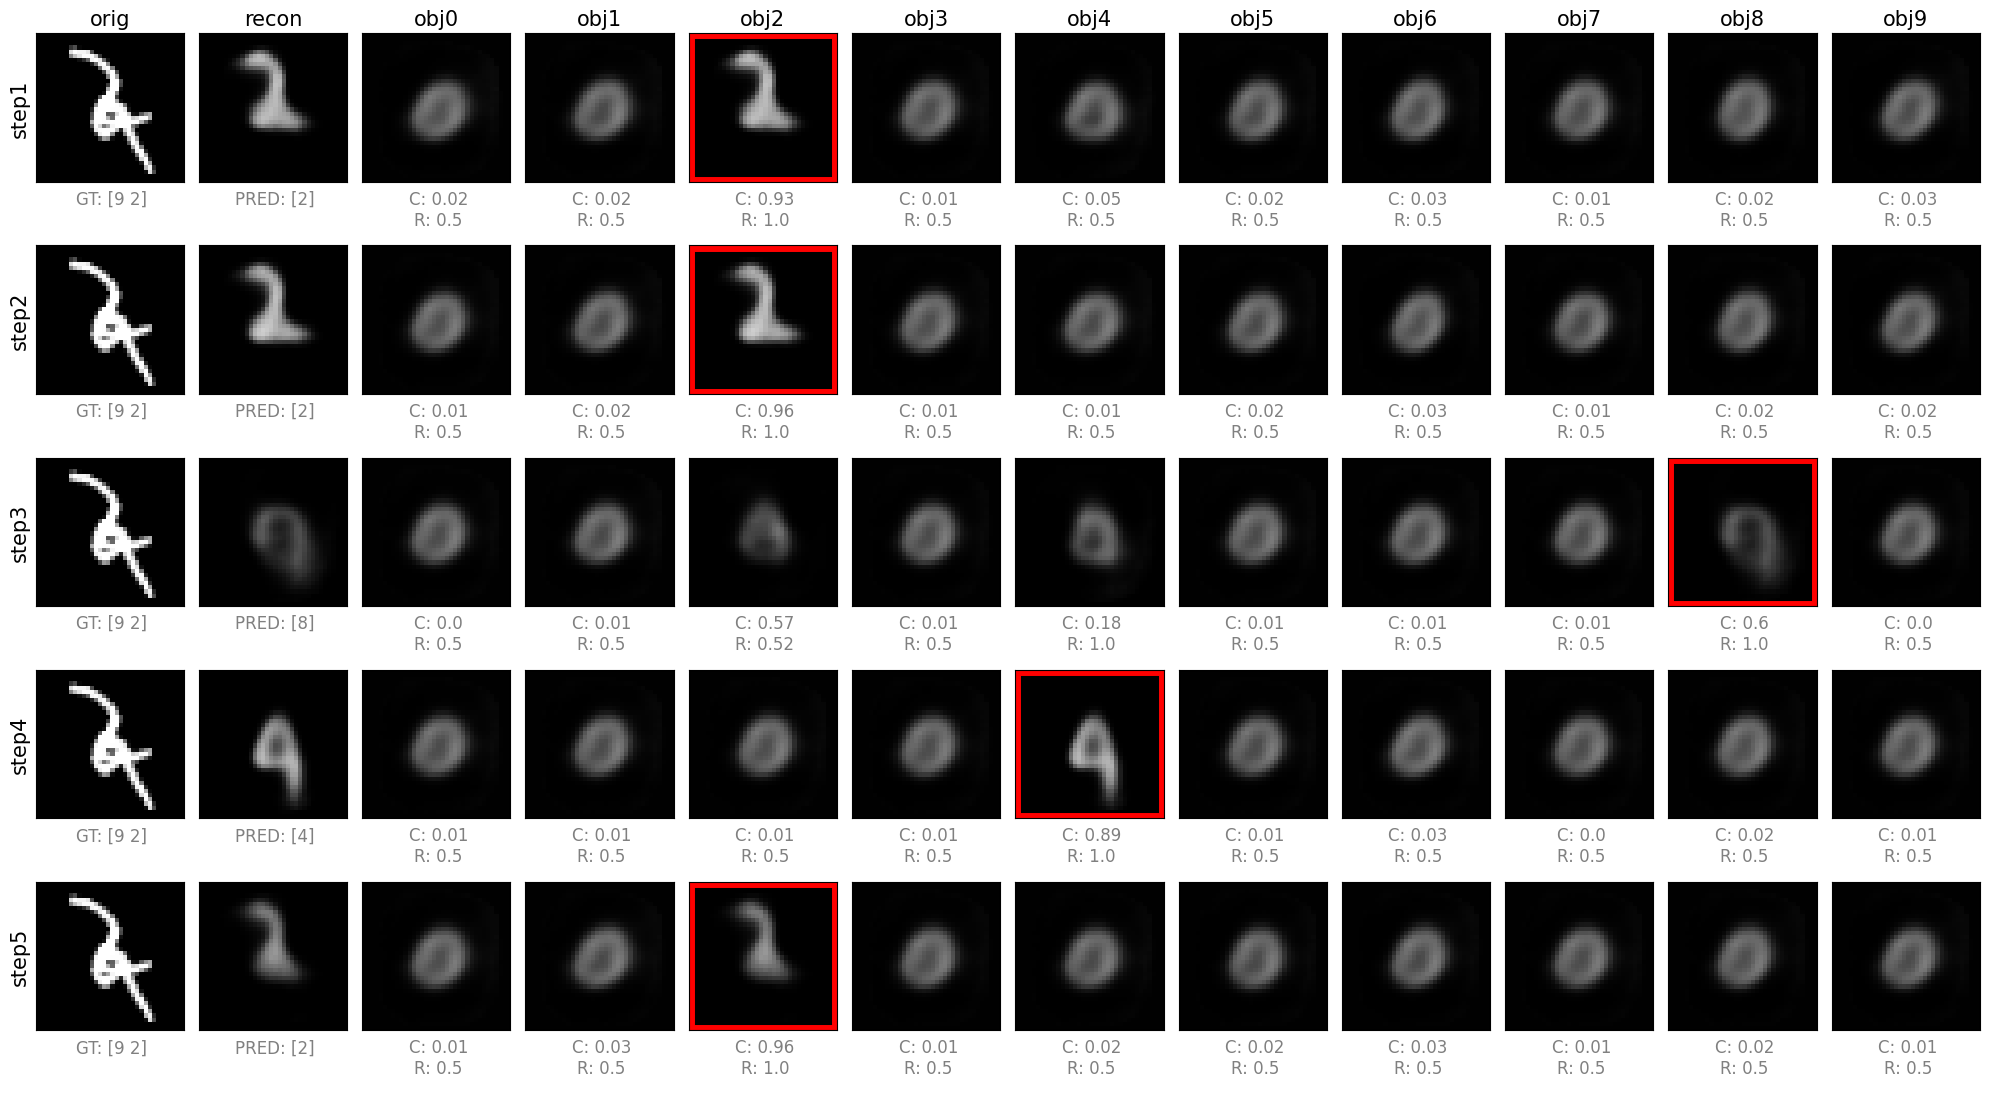



================ TRIAL 5 ===================


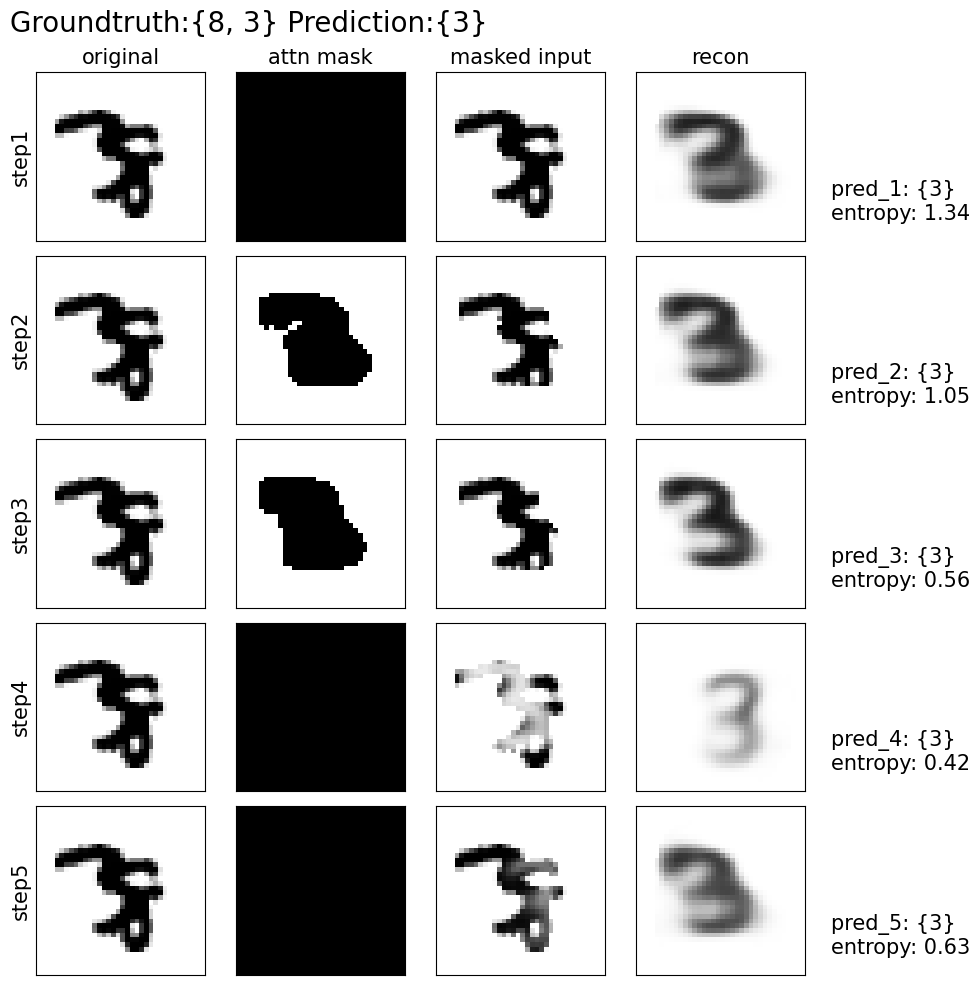

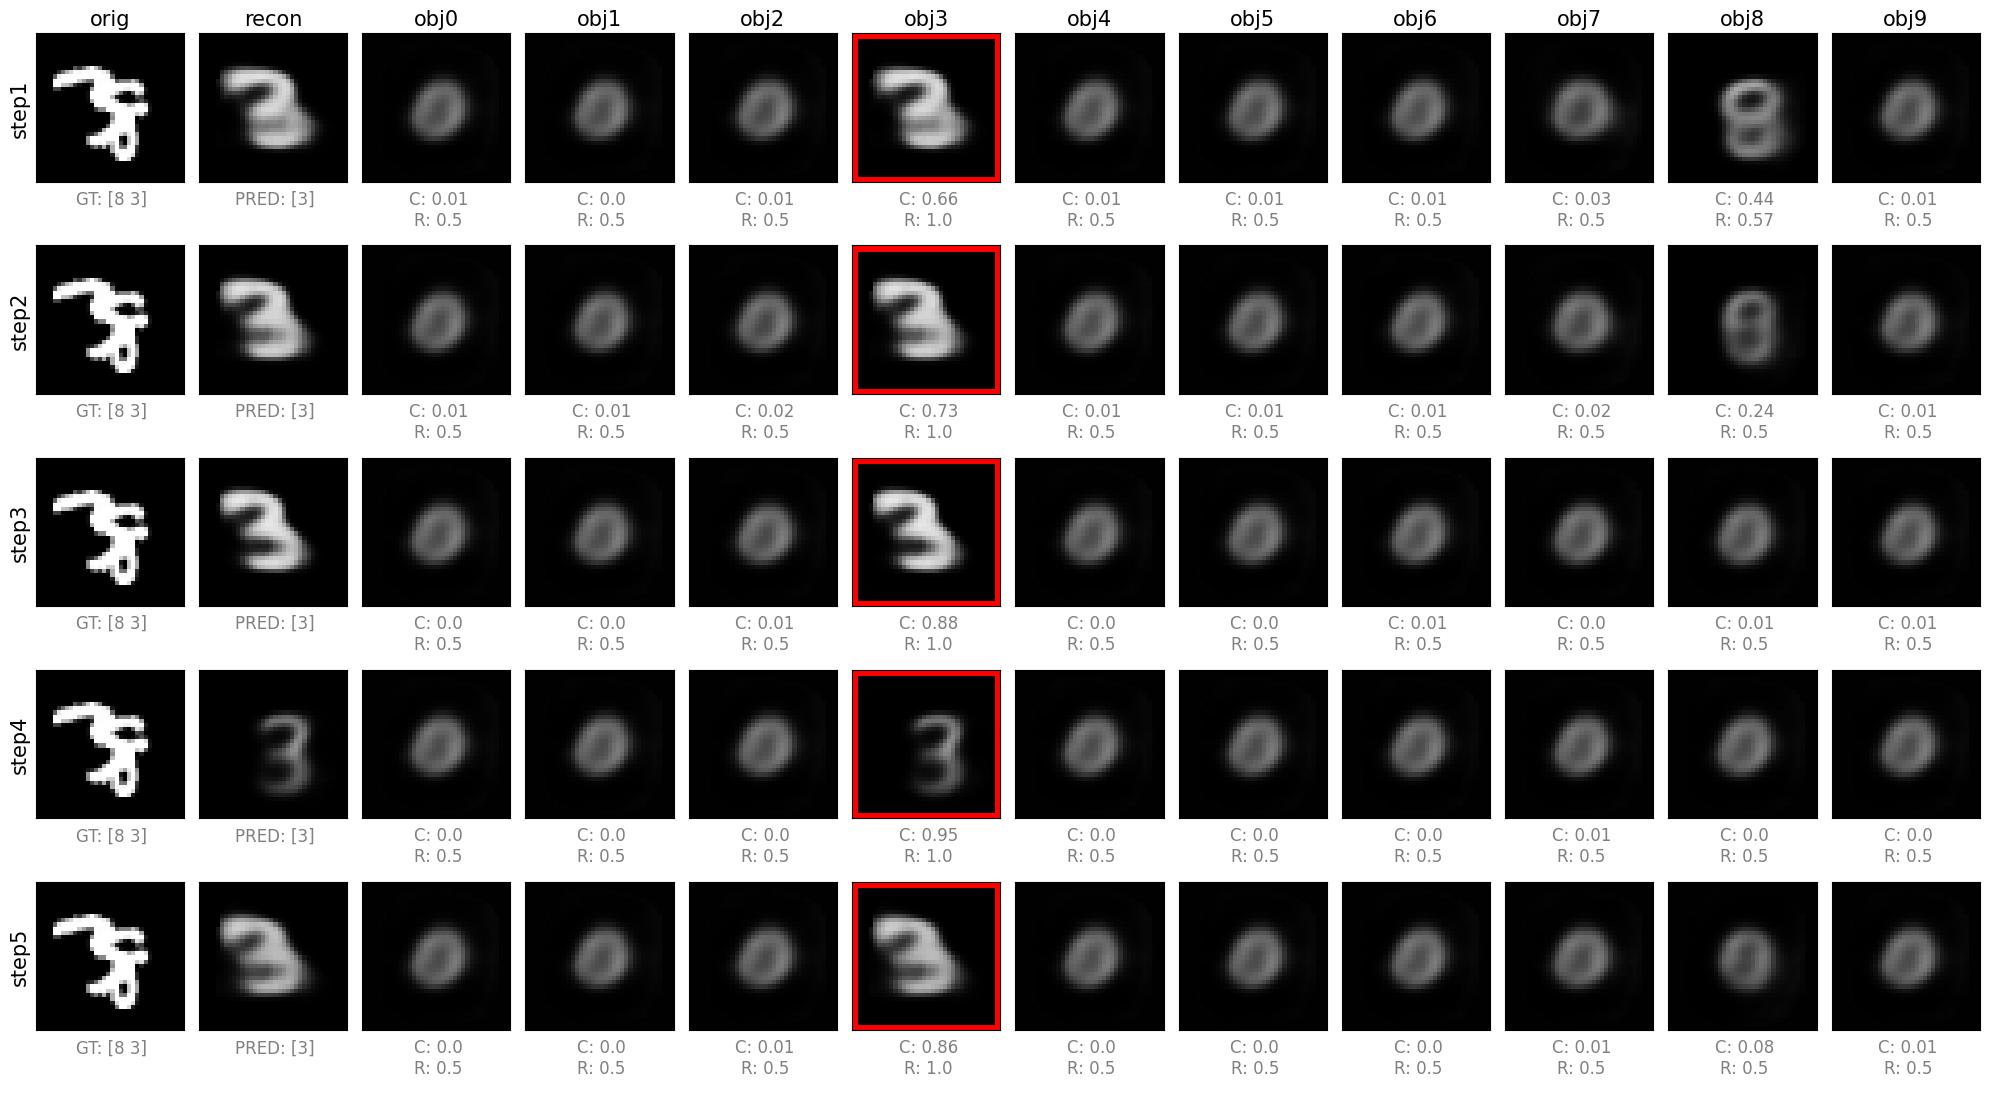



================ TRIAL 6 ===================


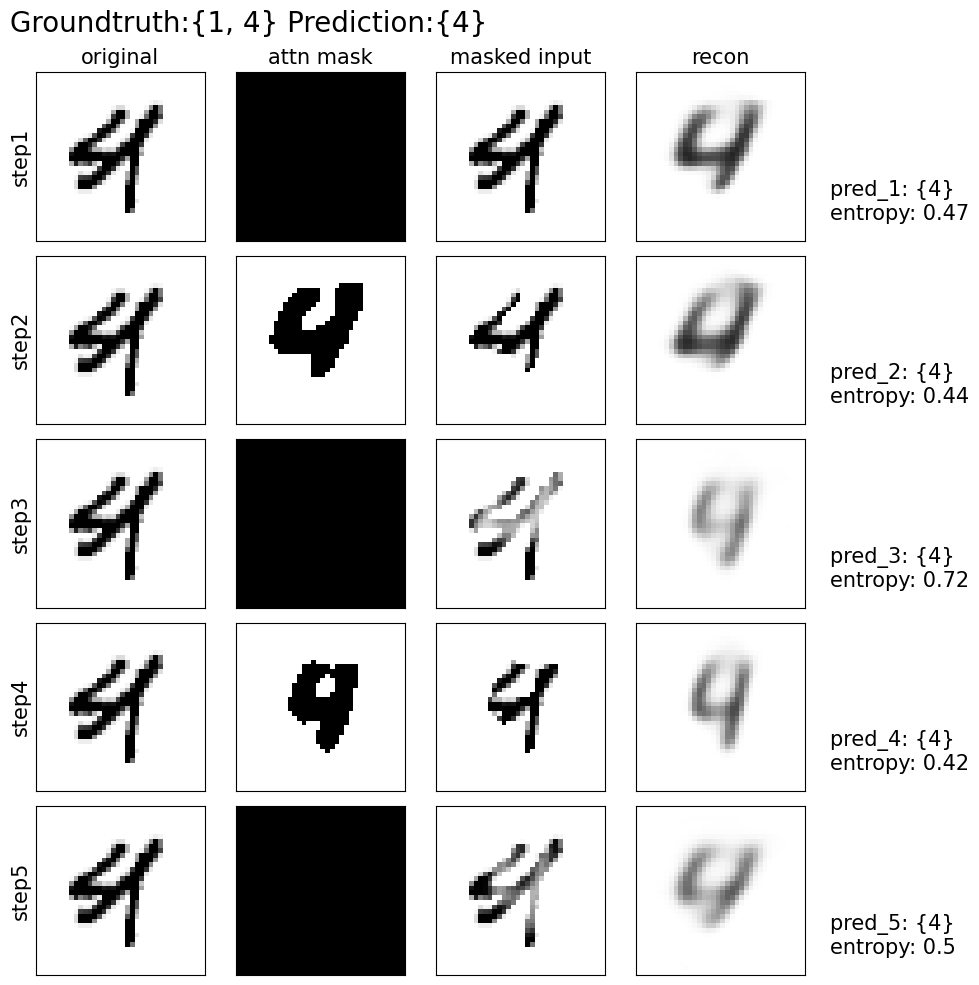

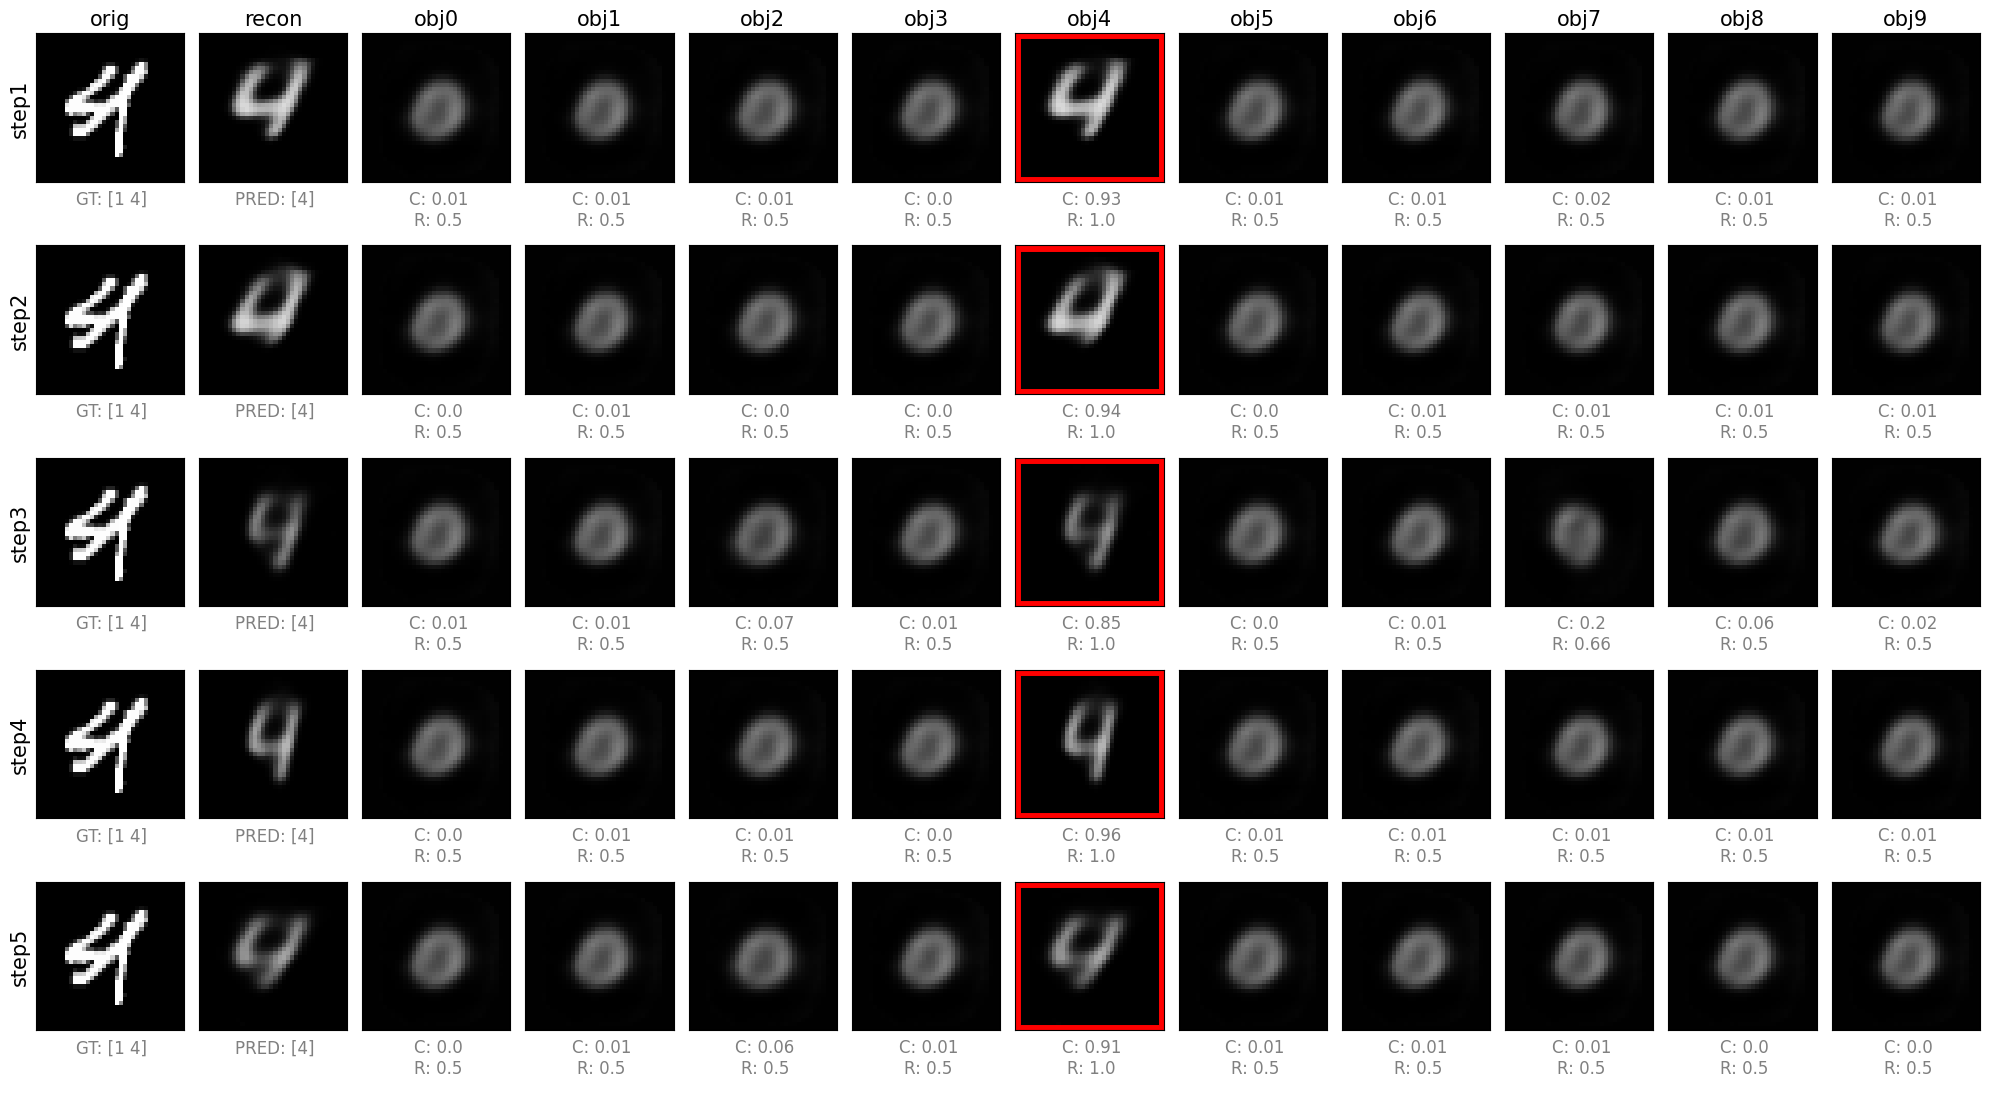



================ TRIAL 7 ===================


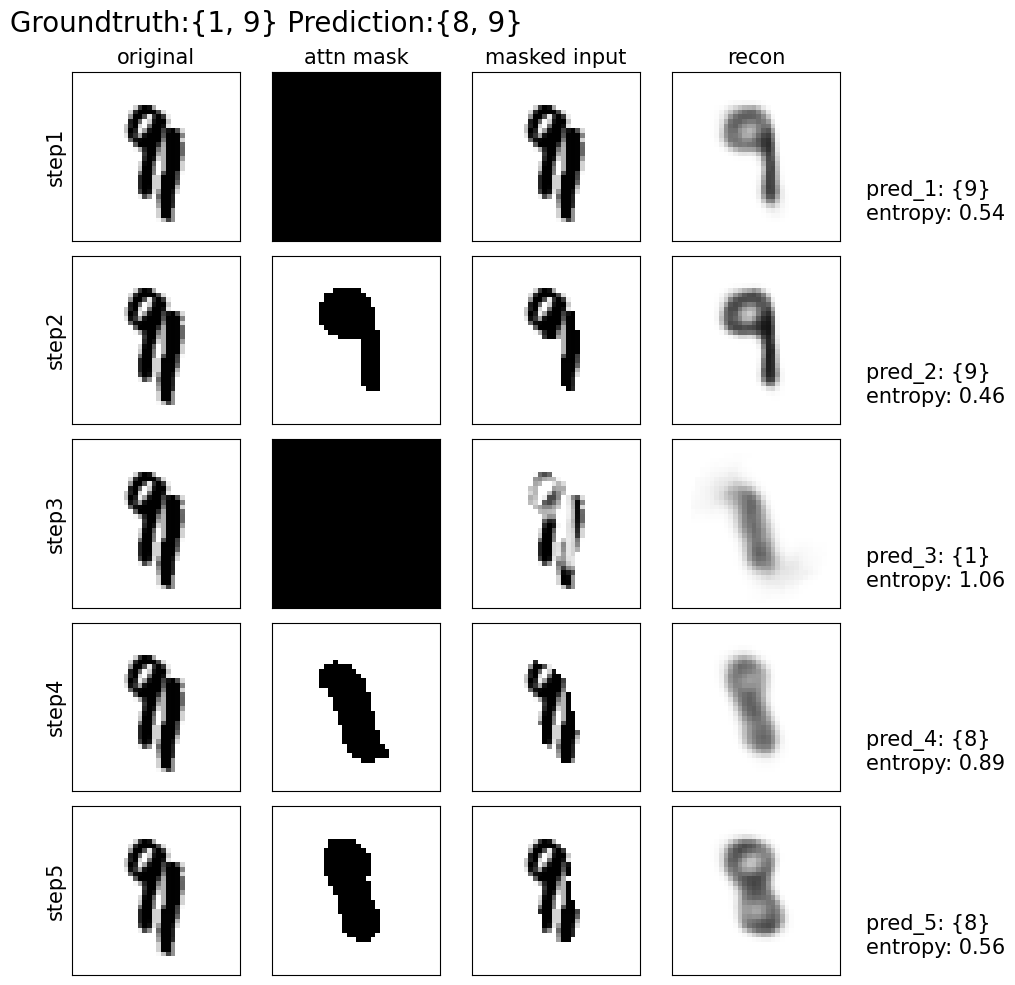

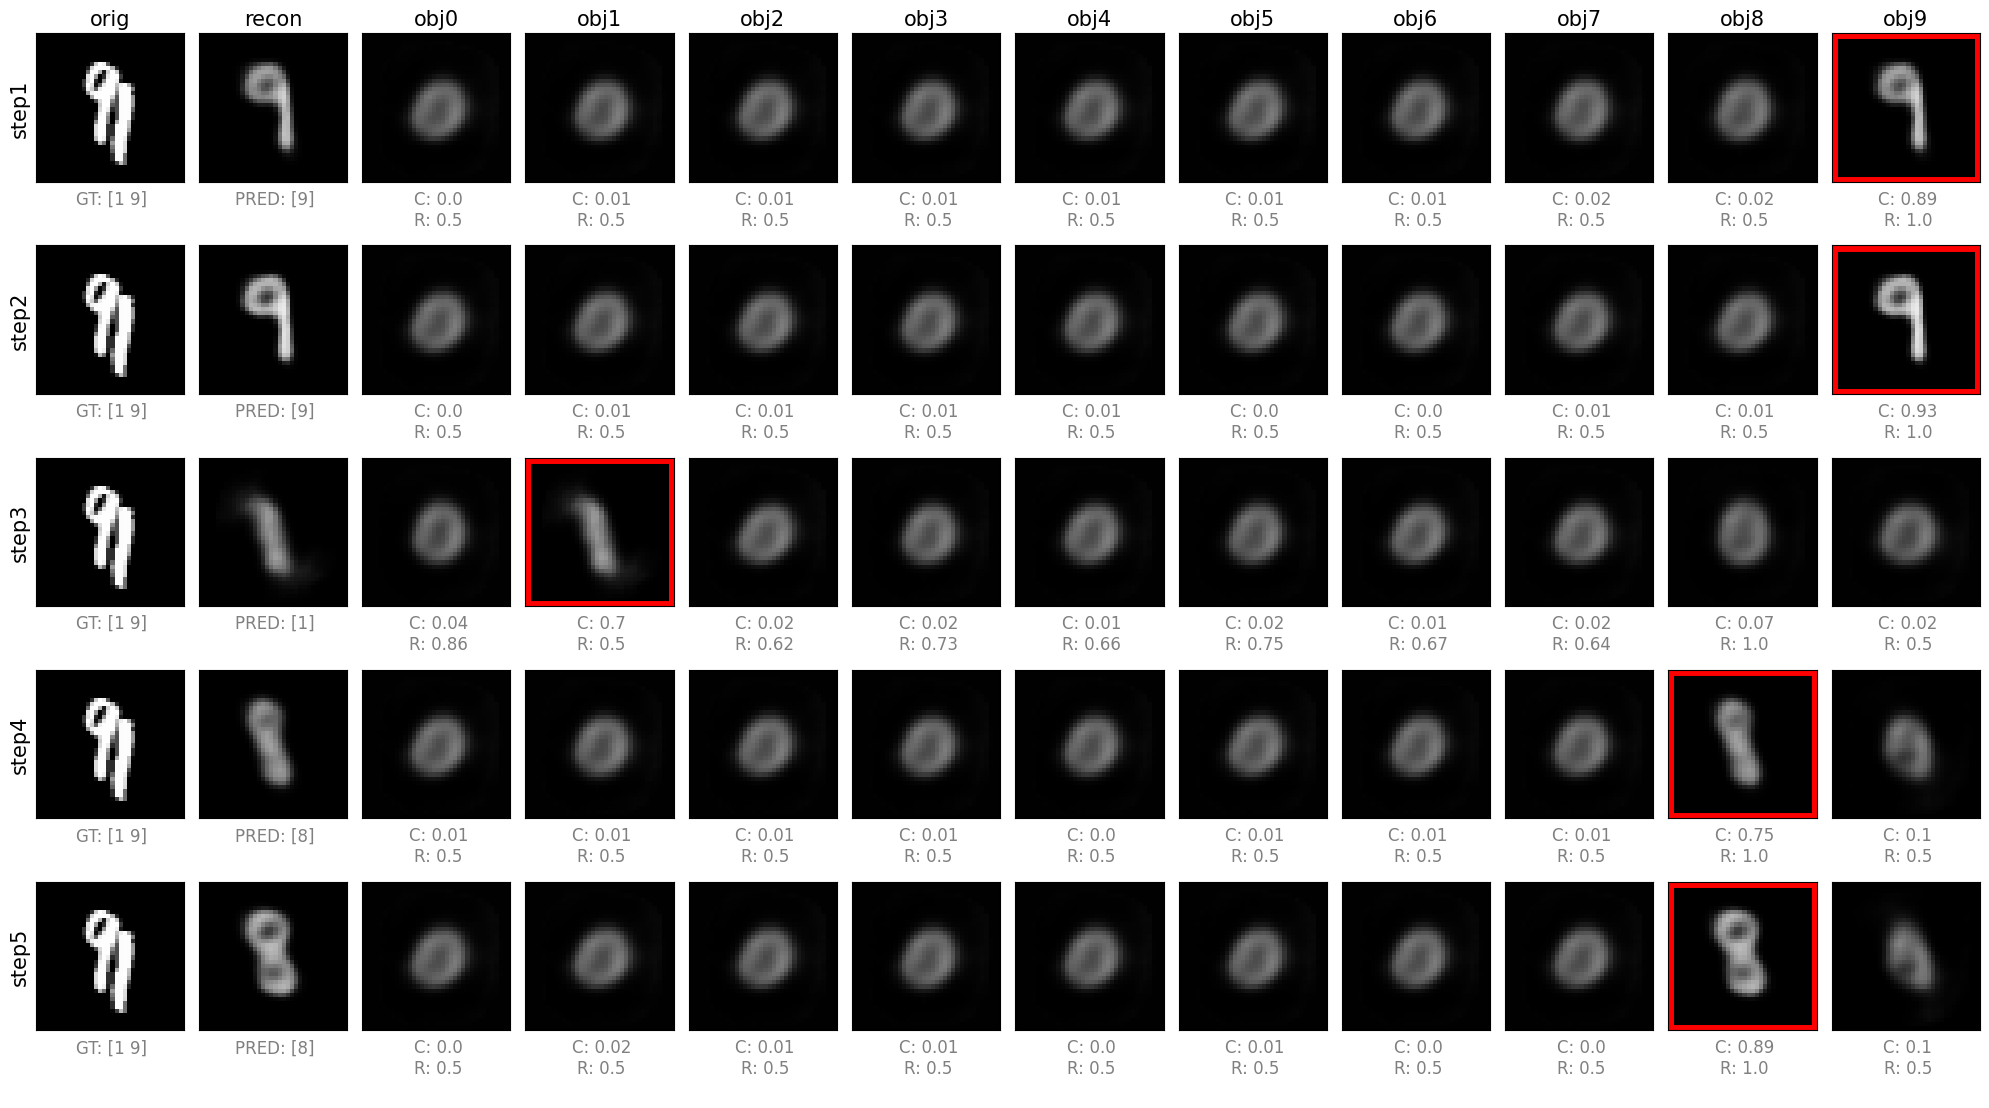



================ TRIAL 8 ===================


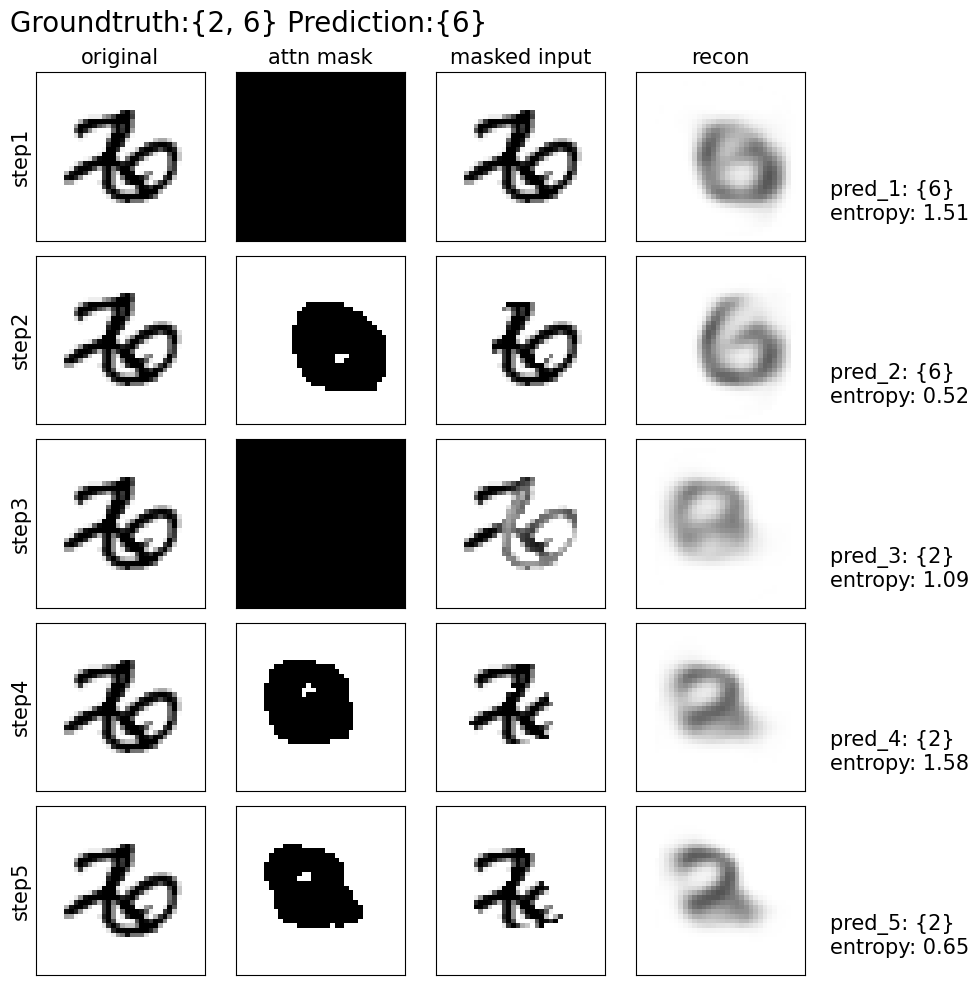

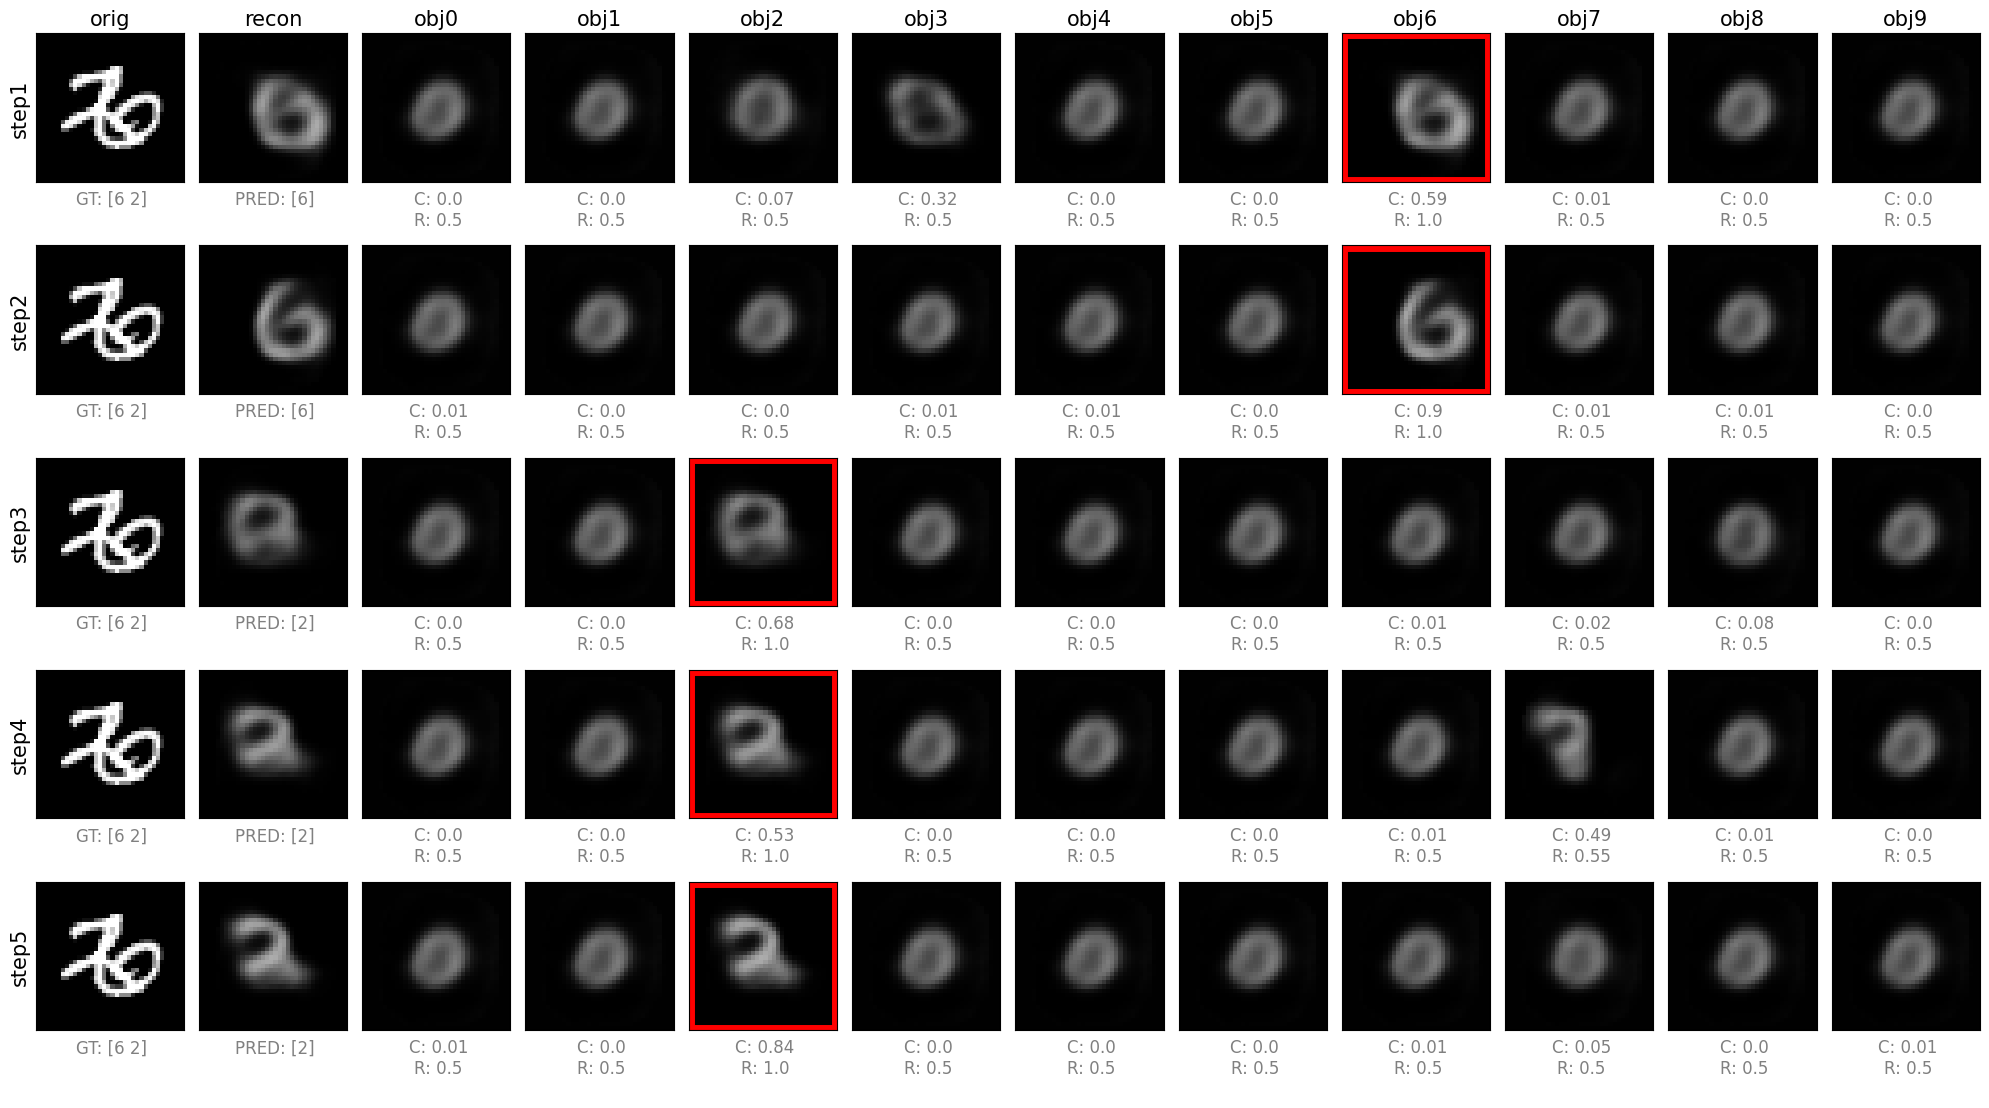



================ TRIAL 9 ===================


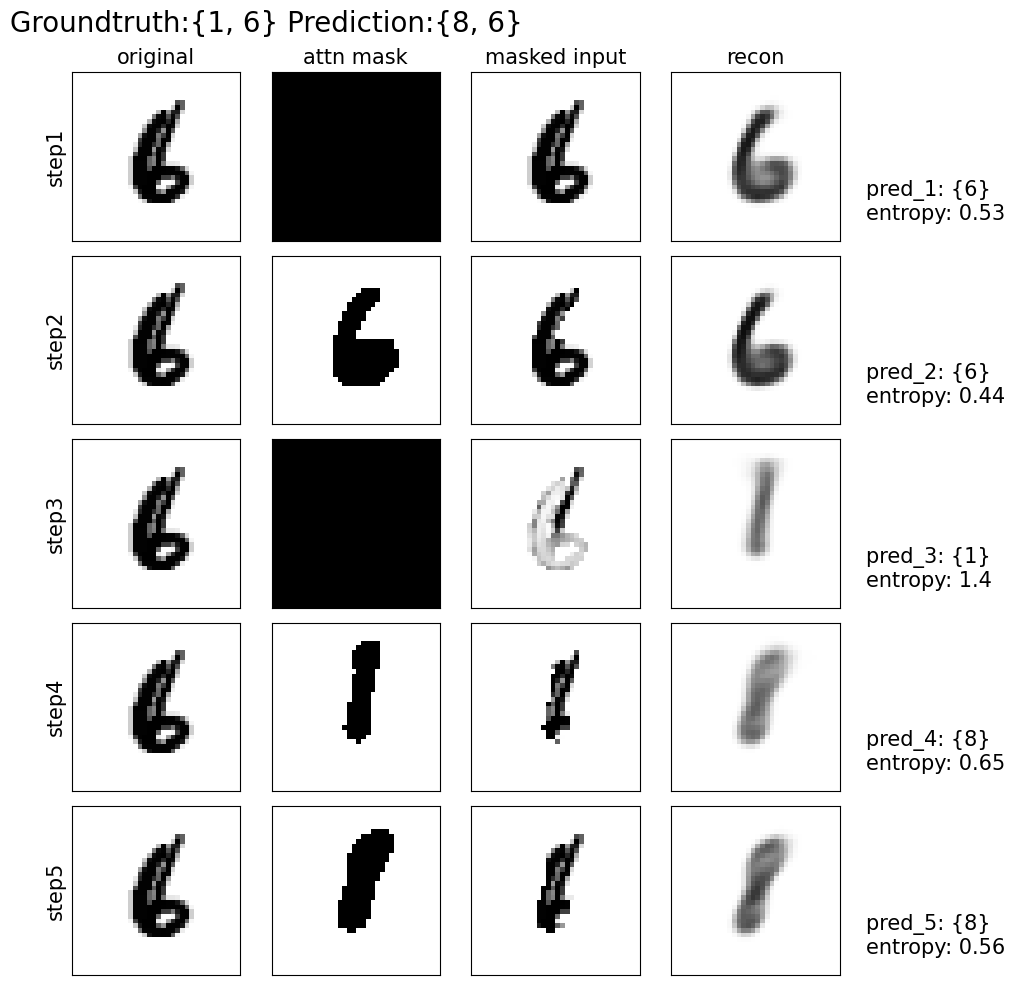

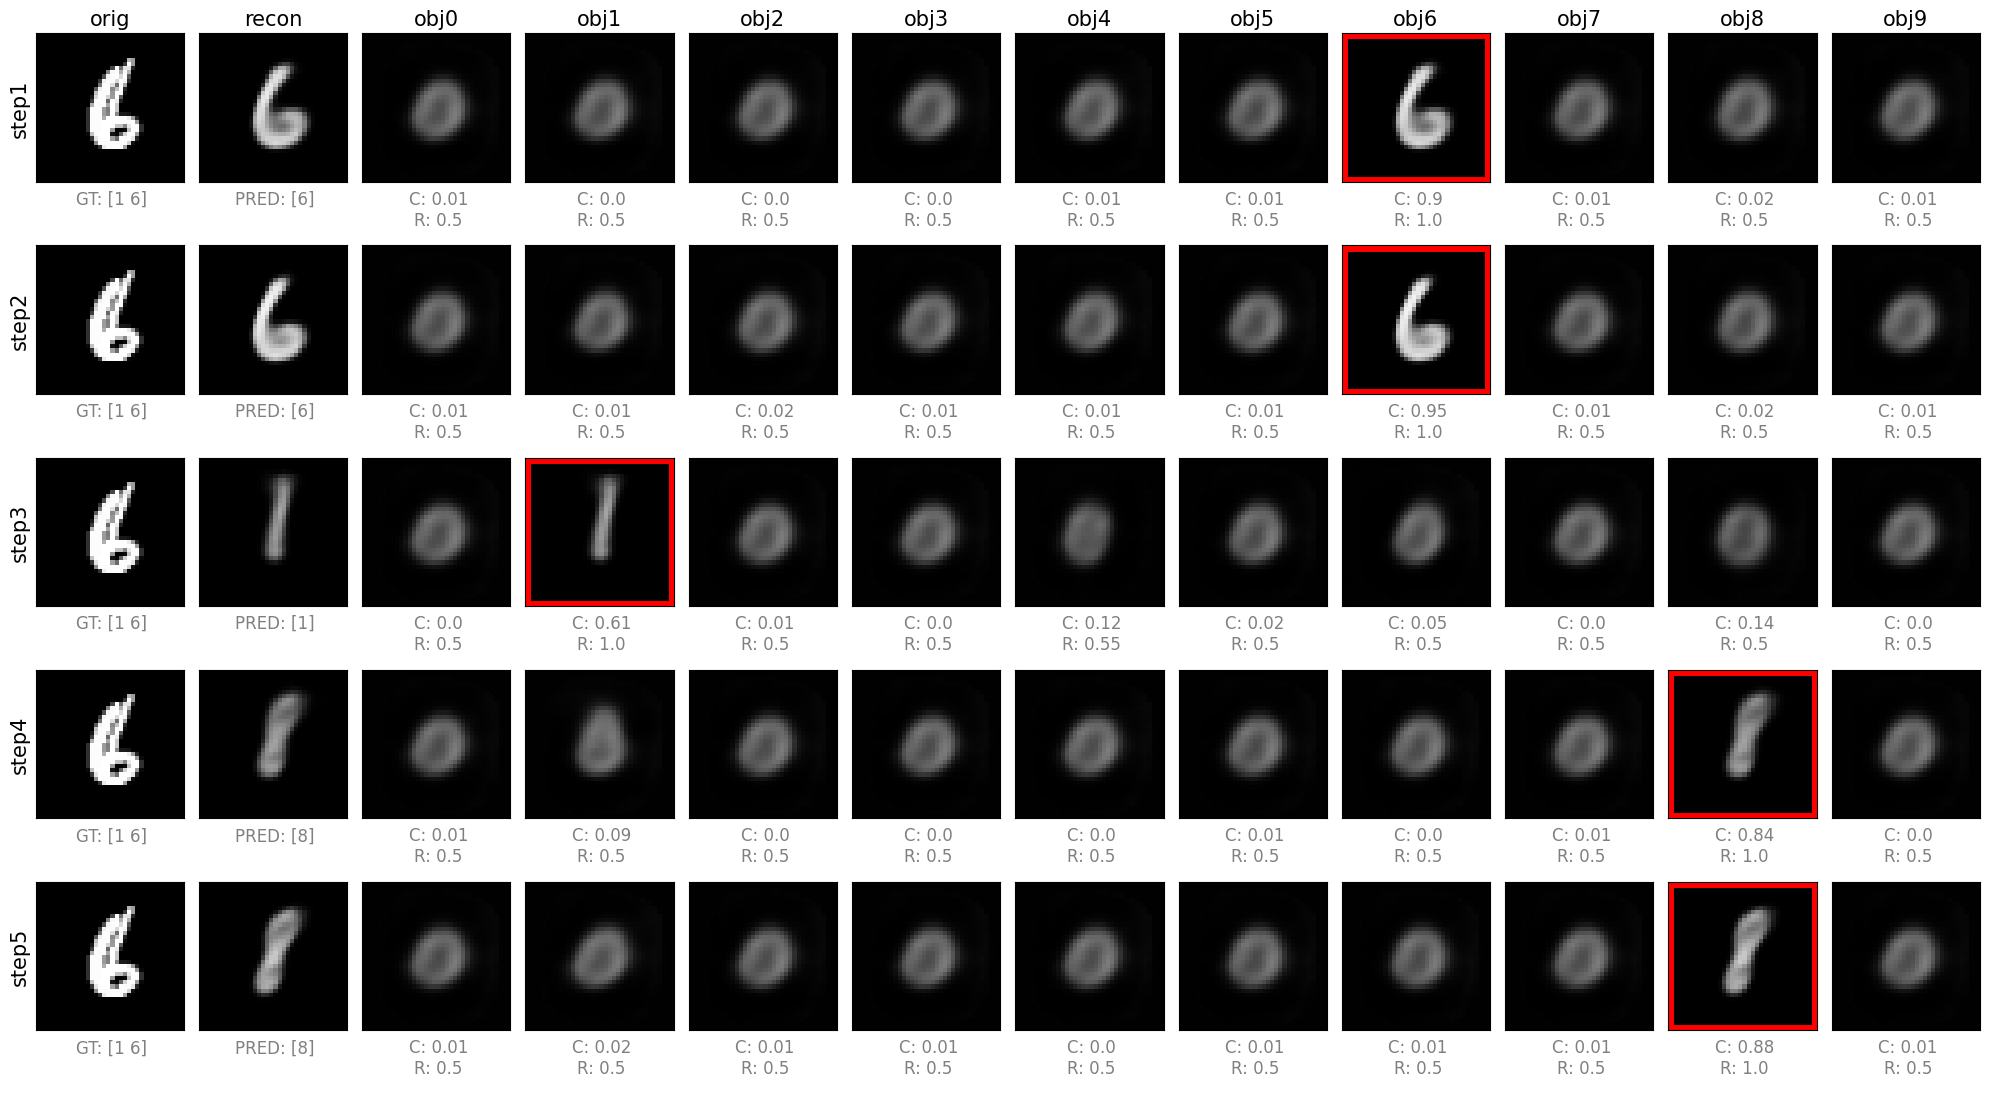



================ TRIAL 10 ===================


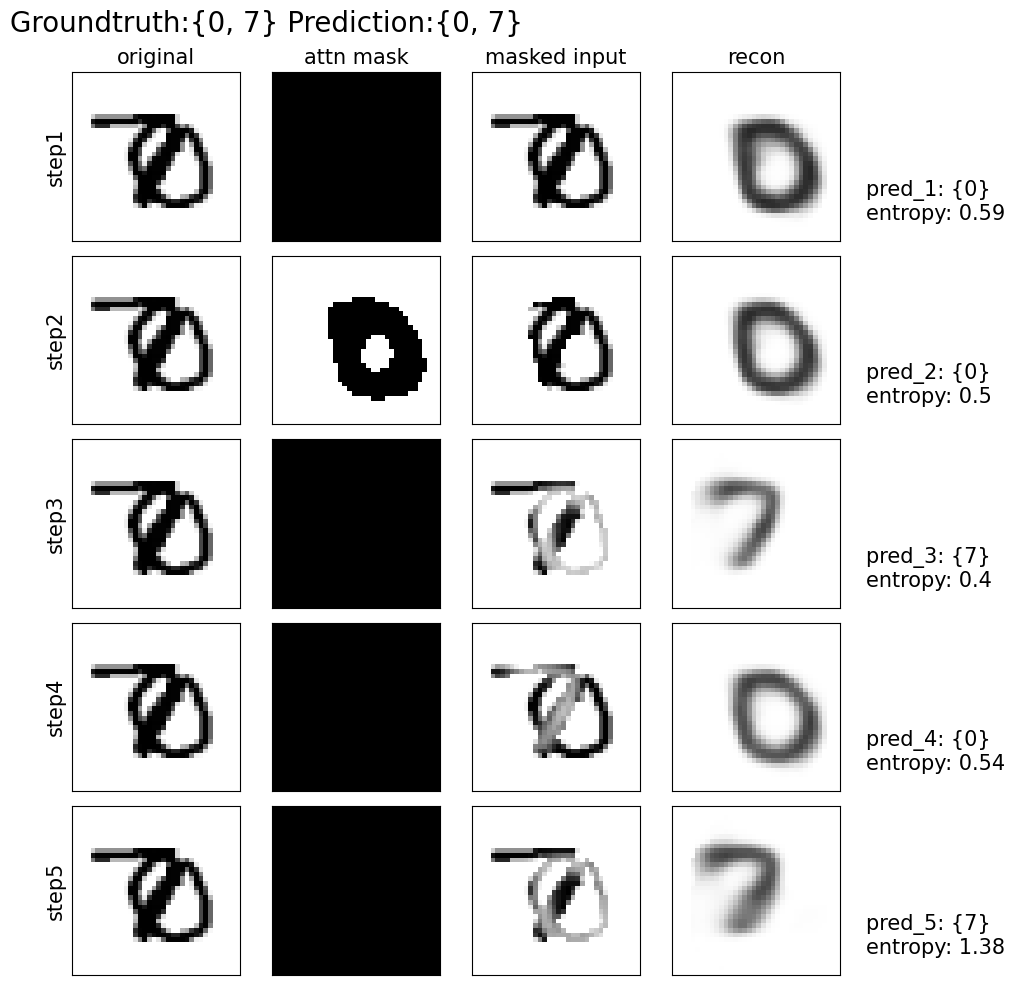

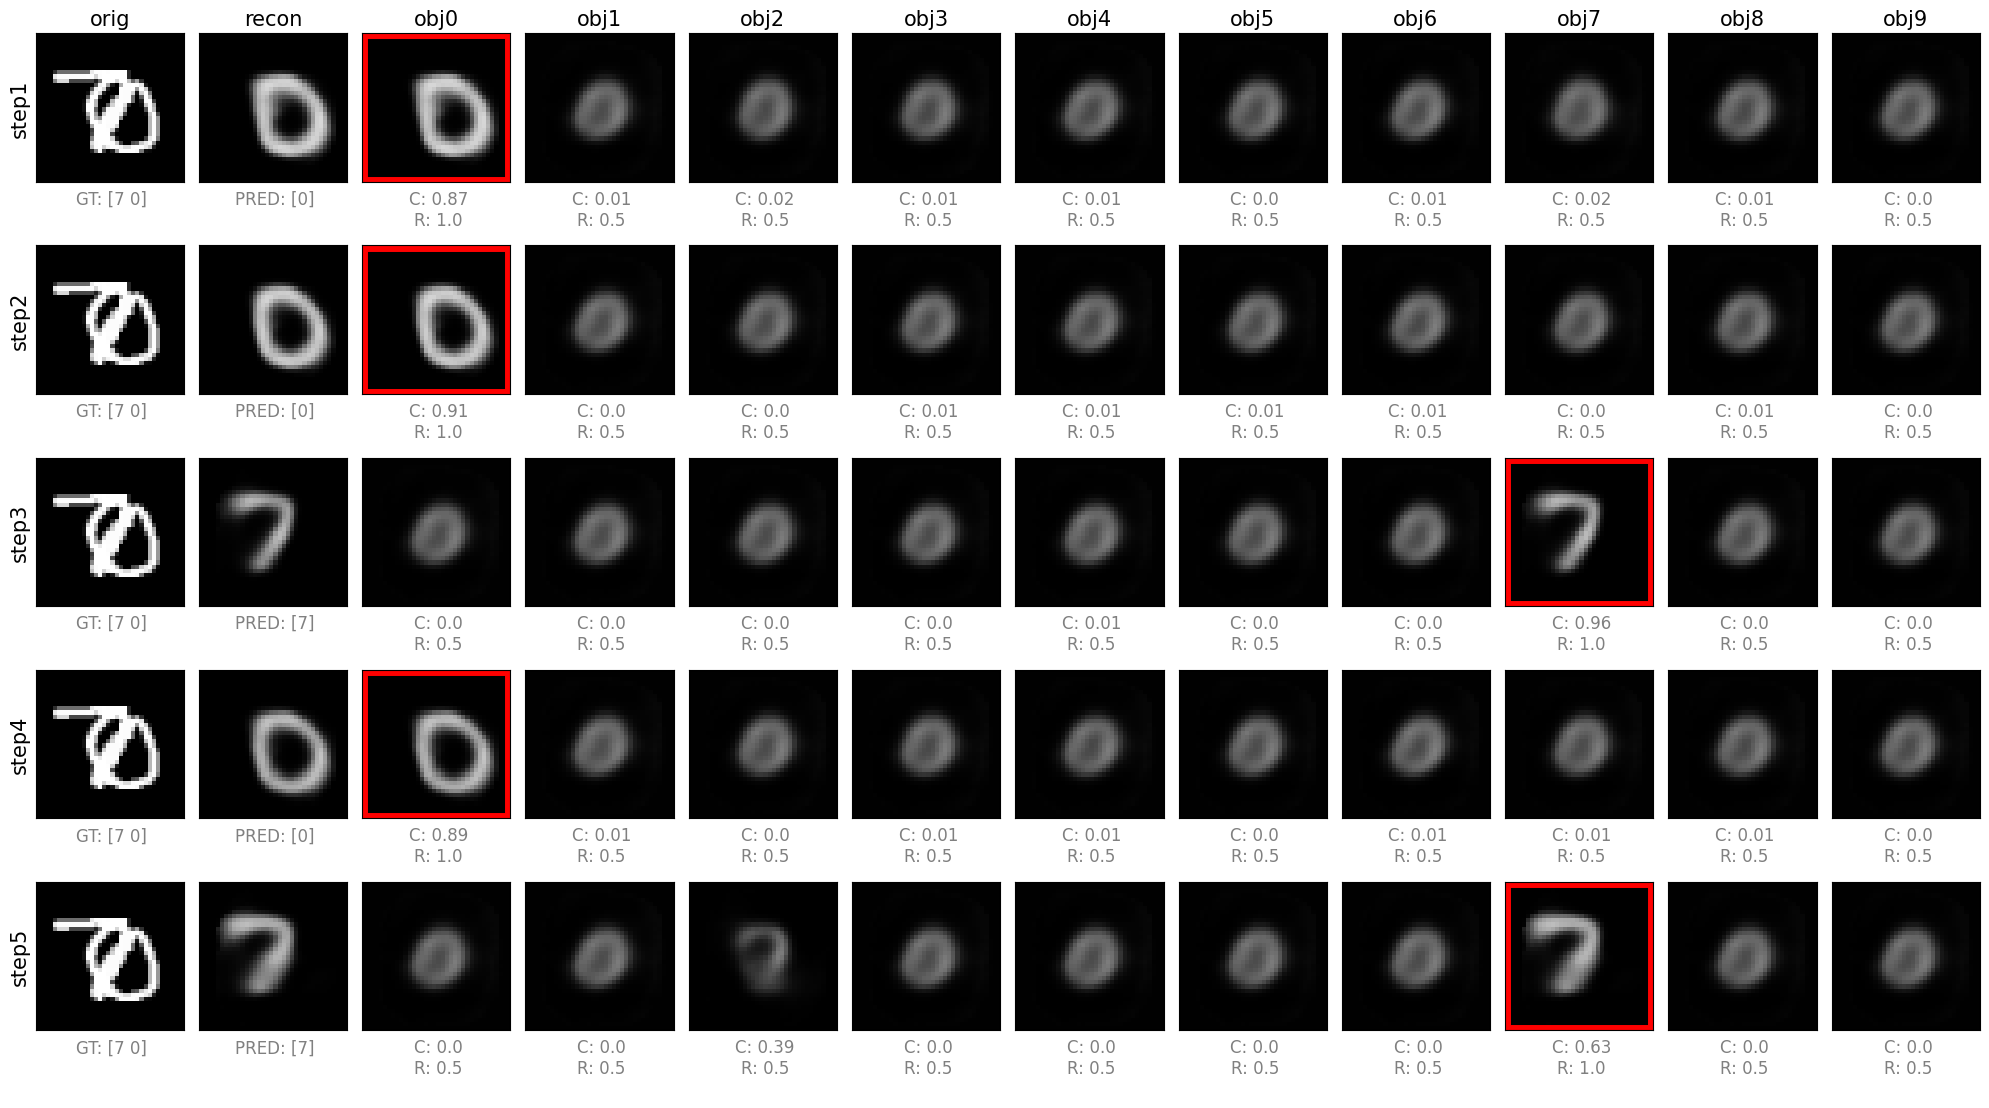



================ TRIAL 11 ===================


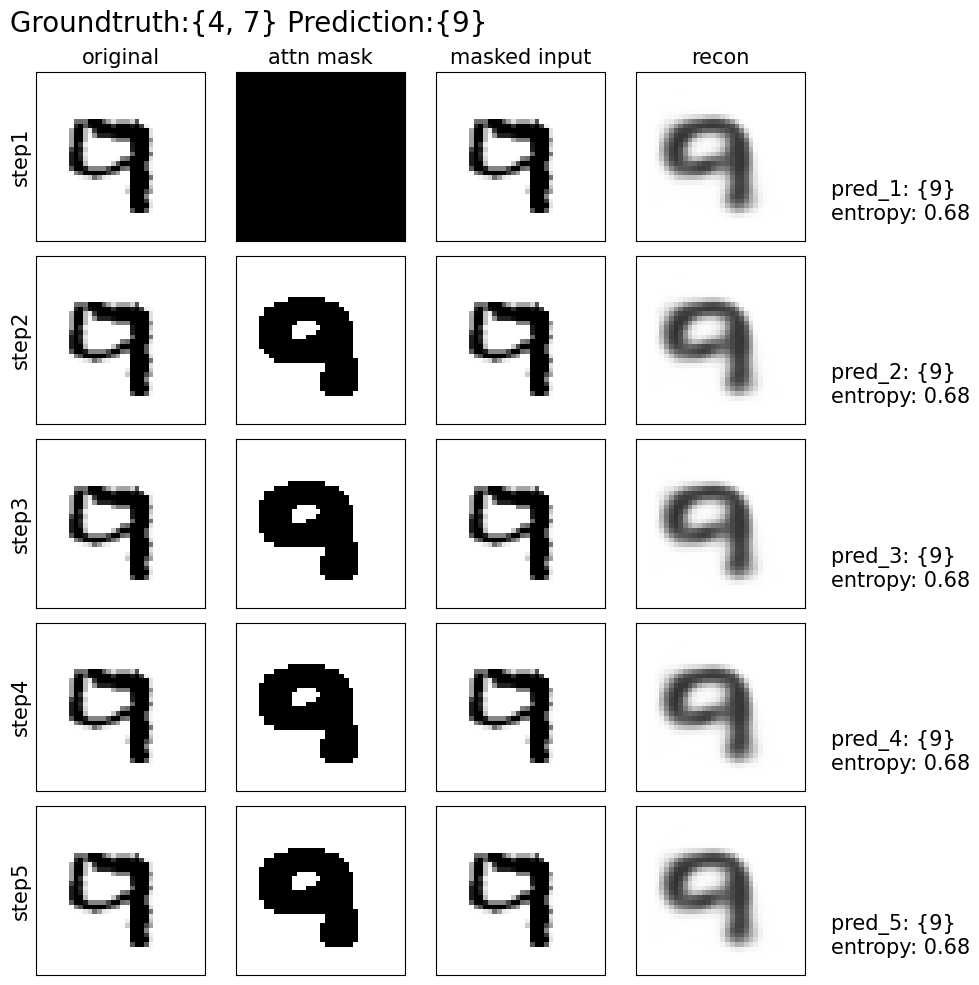

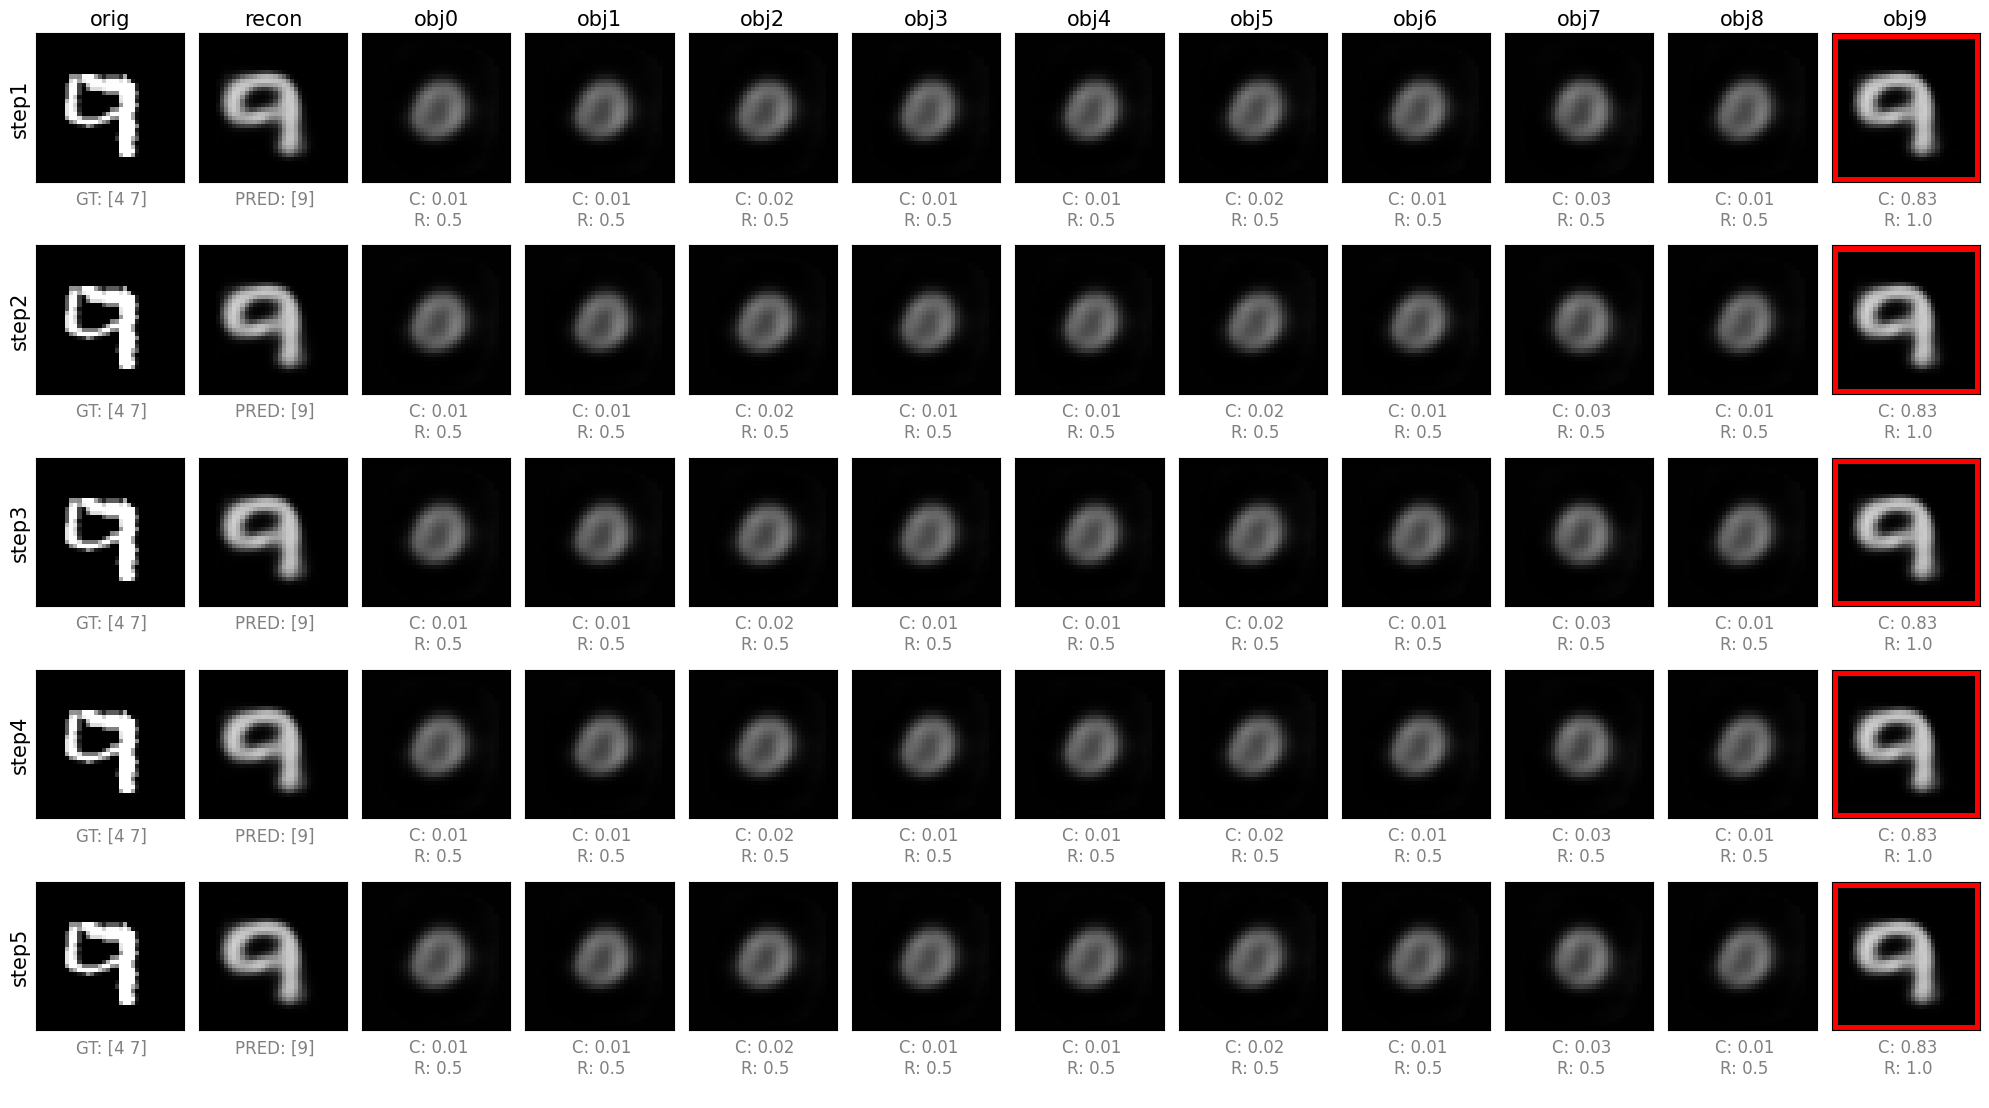



================ TRIAL 12 ===================


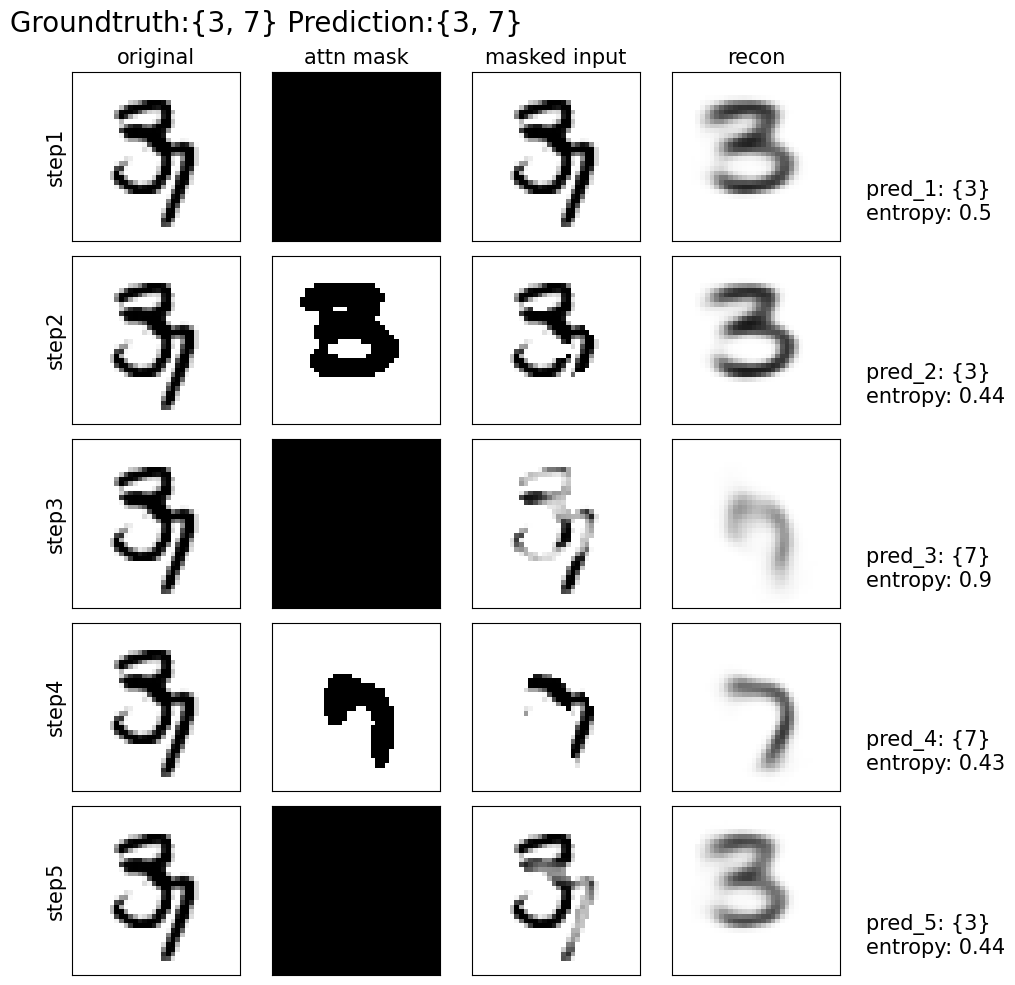

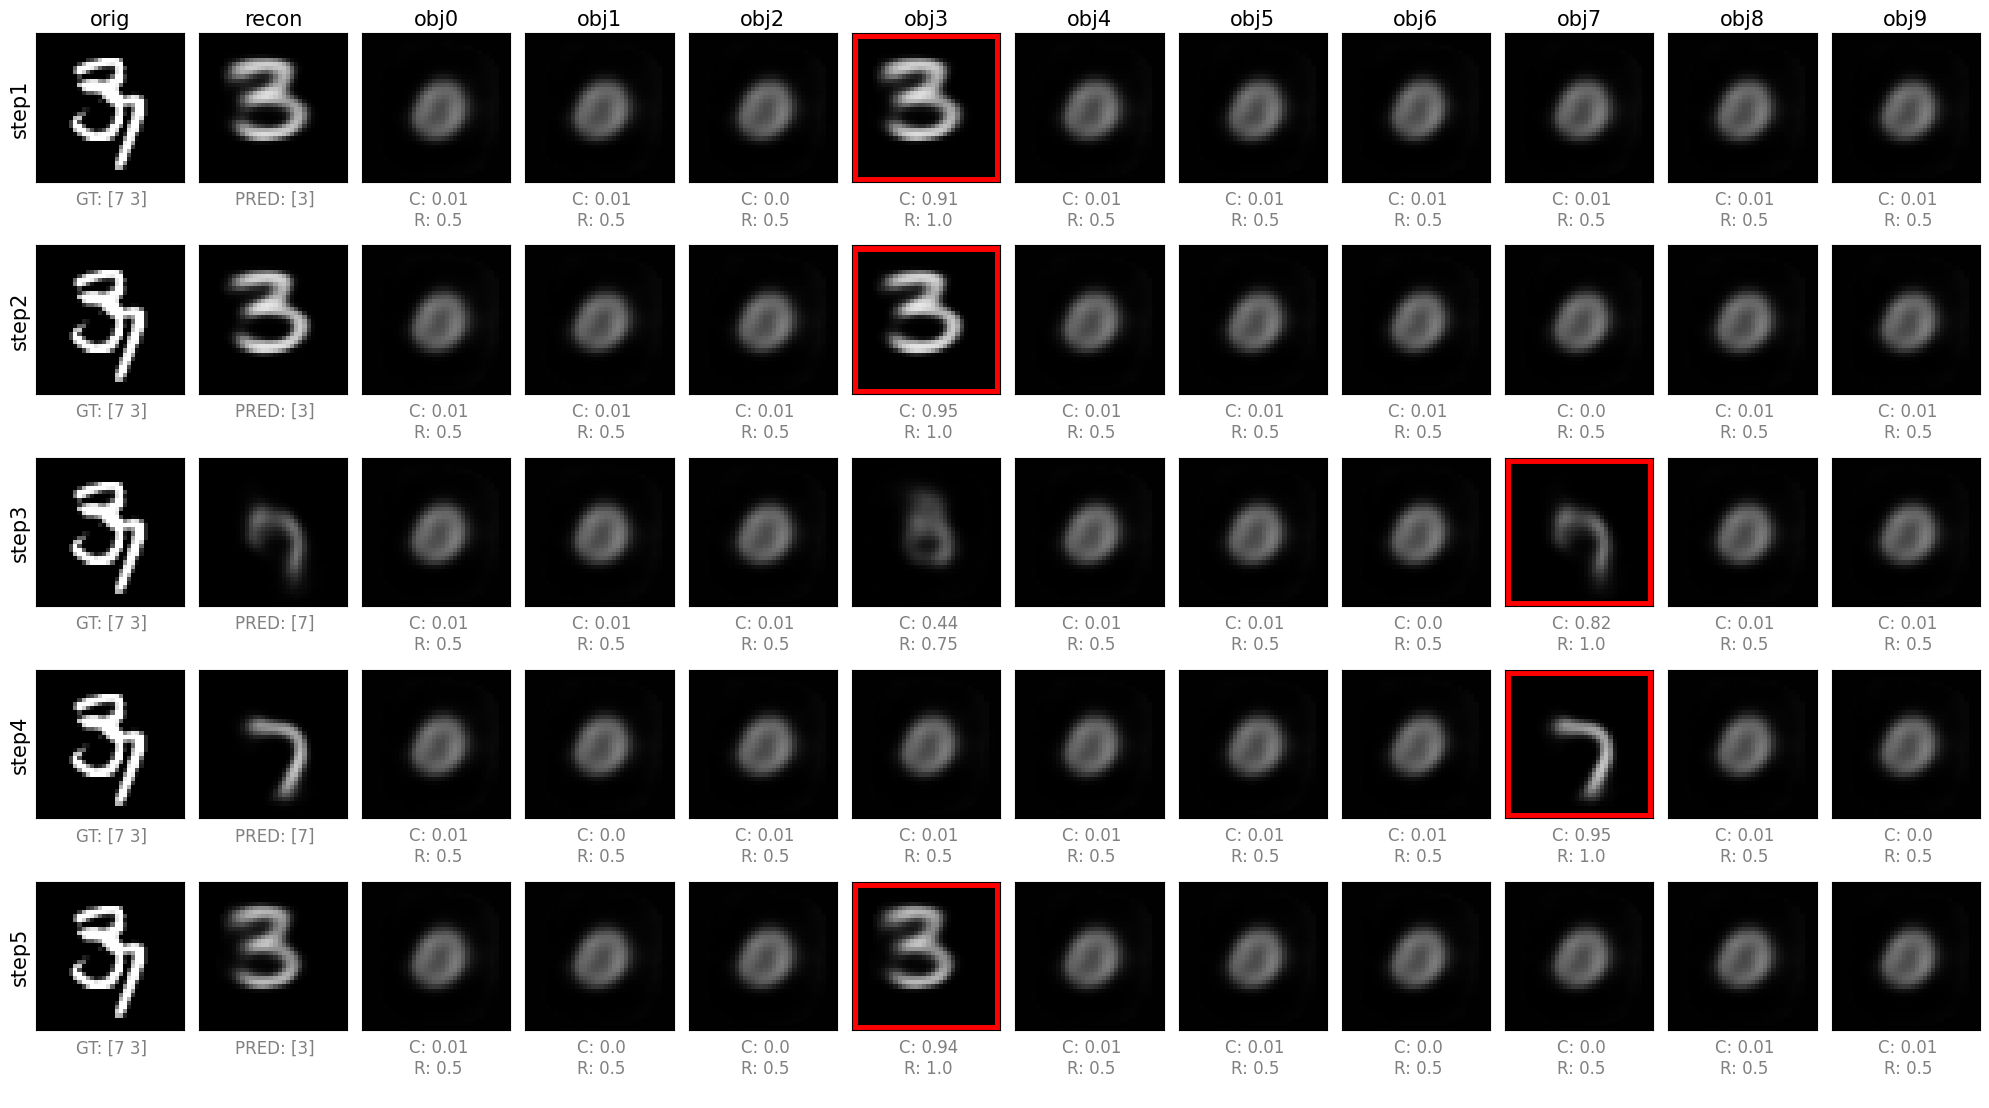



================ TRIAL 13 ===================


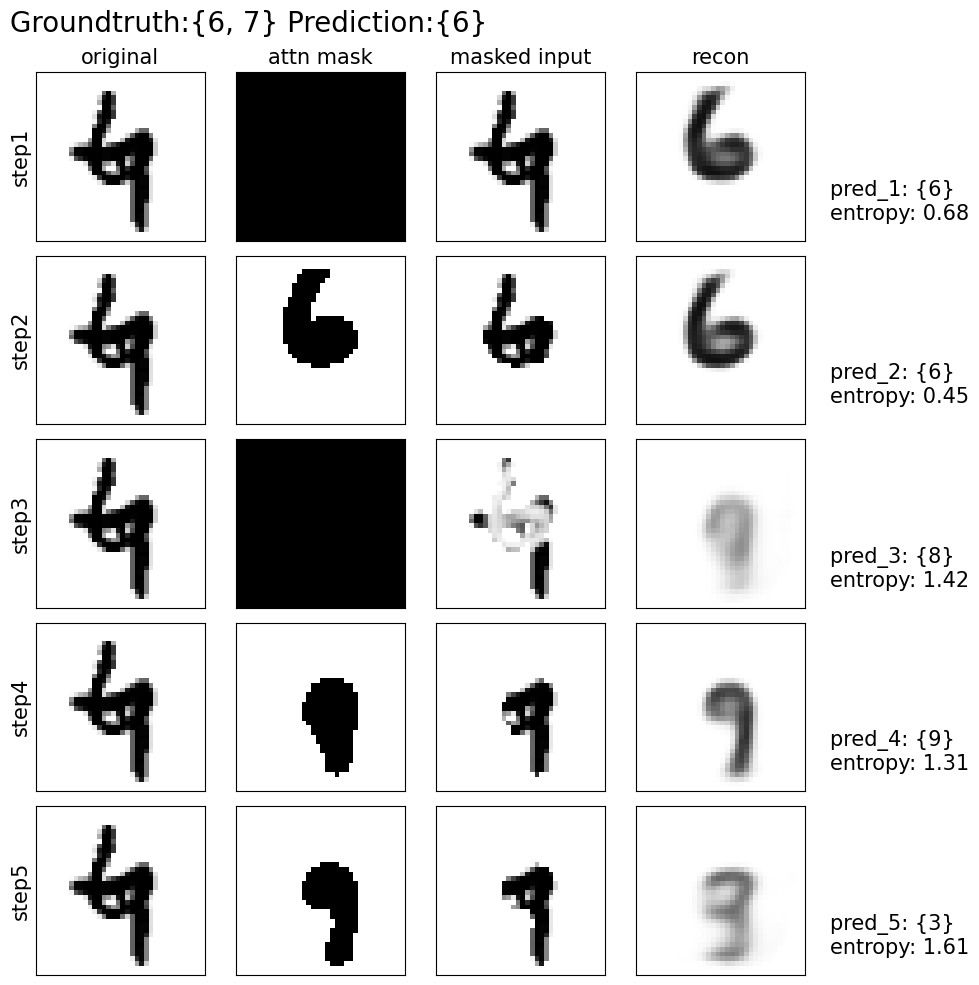

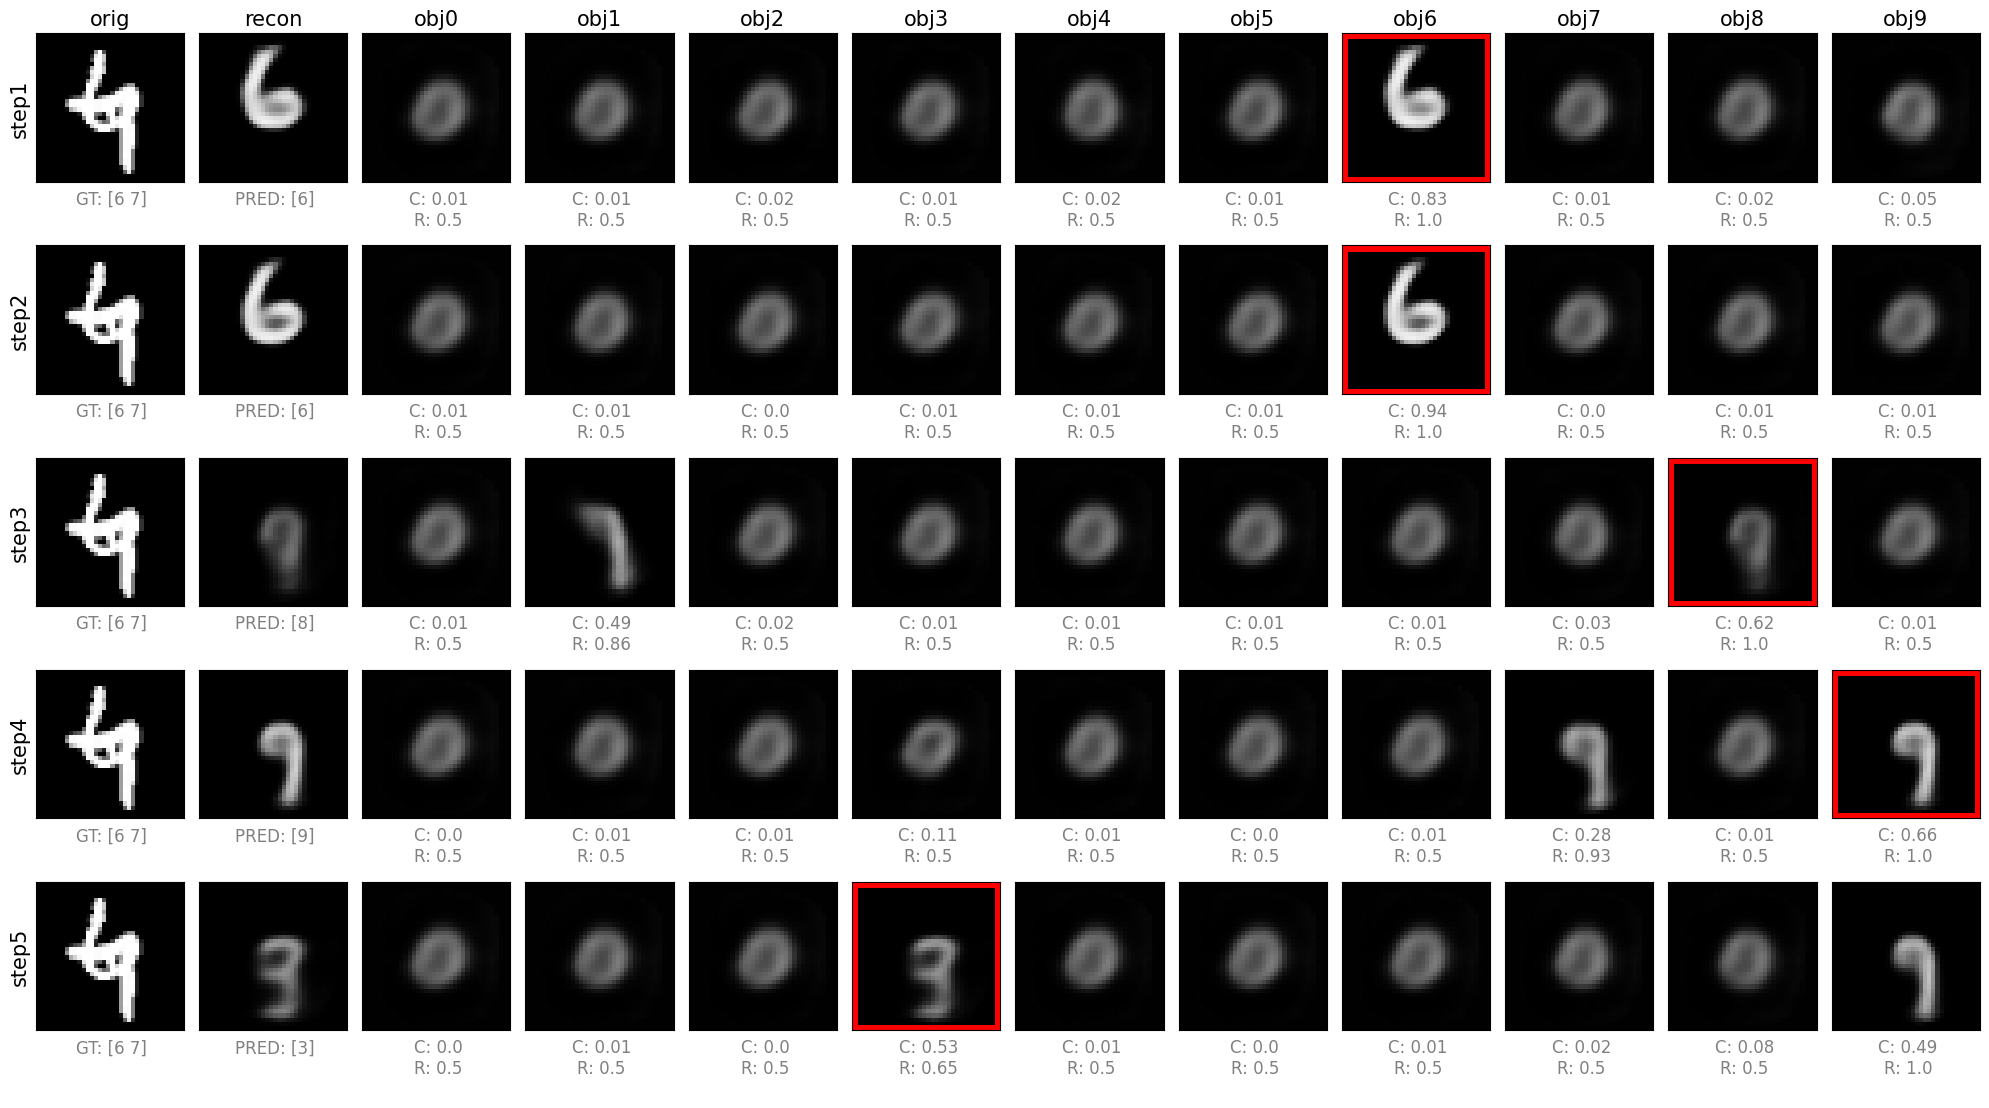



================ TRIAL 14 ===================


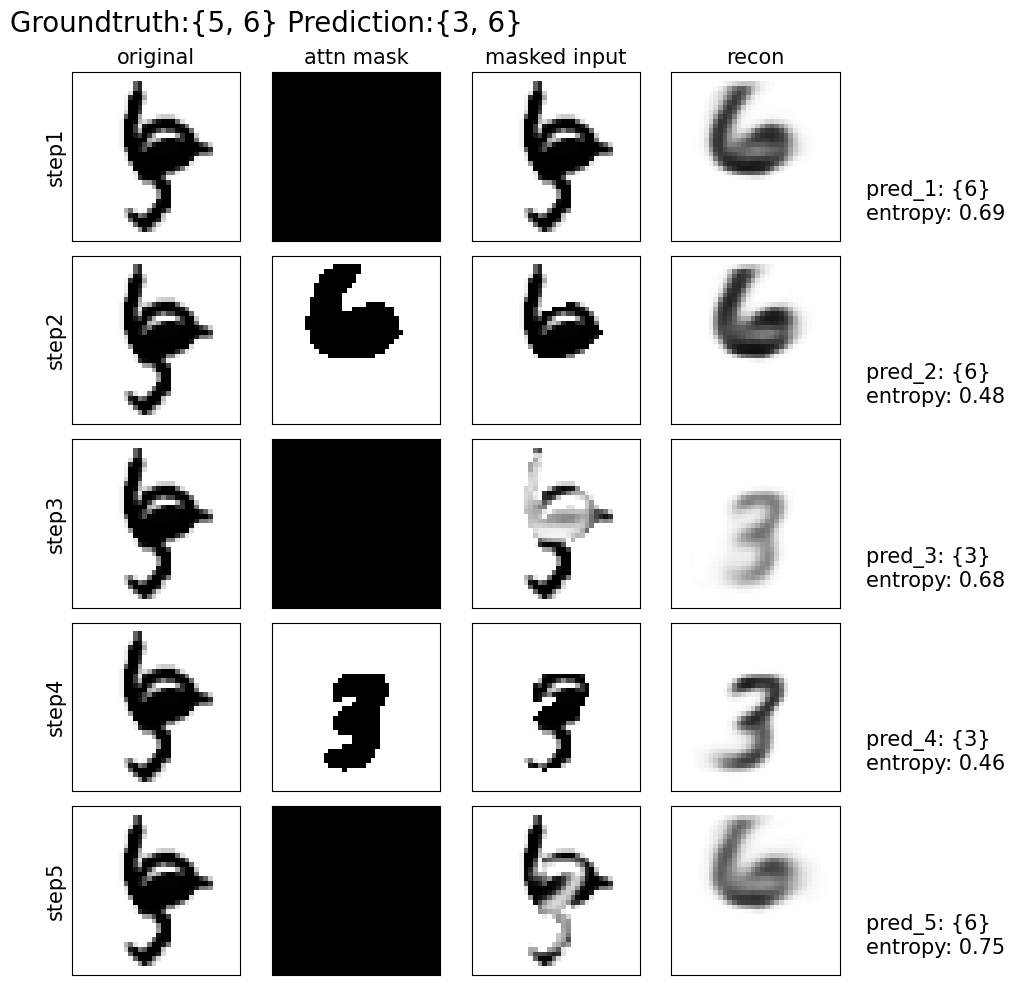

In [37]:
###################################
# stepwise visualization
###################################
idx_start = 0 # can't be higher than batchsize
n_image =100

## plot condition
# condition = 'first correct last incorrect'
# condition = 'first incorrect last correct'
# condition = 'first incorrect last incorrect'
condition = 'all'
# condition = 'correct'
# condition = 'incorrect' 

## plot only specific categories
# idx_category =3
# boolidx1 = y_hot.argmax(dim=-1).numpy()==idx_category
# condition = list(np.where(boolidx1==True)[0])

## plot different steps
# n_step = 2
# boolidx2 = (nstep==n_step).cpu().numpy()
# condition = list(np.where(boolidx2==True)[0])
# condition = list(np.where(boolidx1*boolidx2==True)[0])

## plot by ids 
# condition = [6, 41, 66]
# condition = [7, 11]
# condition = [66, 114, 656] #batchnum1
# condition = [6] #batchnum2
# condition = [6] #batchnum3
# condition = [17]
# condition = [8] #batchnum 3
# condition = [22, 33,41,44,75,82,88,147] #fog batch
# condition = [6,7]
# condition = [17]
# condition = [447]
# condition = [167, 502, 1466]

# condition = trialid_to_visualize #[:20]
# condition = list(np.where(nstep==3)[0])
# condition = [309]
# condition = [560, 893]
# condition=[7]
# condition=[82, 92]

# condition = [329,336]
# condition = [410]
# condition = [110, 12]
# condition = [94, 299,527]
# condition = [133] #9 and 4
# condition = [94] #routing

args.num_targets= 1
idx_plotted =\
visualize_detail(model, x.to(DEVICE), y_hot.cpu(), outputs_model, 
                 x_recon_step, objcaps_len_step, args,
                 start=idx_start, n_image=n_image, plot_trials_when = condition,
                 plot_routings= False, 
                 pred_to_compare= None, 
                 num_steps_to_finish= None, #[1]*len(x),#list(nstep.cpu().numpy()),
                 entropy = entropy_step, #entropy_model
                 final_pred = seq_pred,
                )